In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import math
#from google.colab import drive
#drive.mount('/content/drive')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )

torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

In [2]:
import torch.nn as nn
import os
torch.manual_seed(42)


class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons, regularization_param, regularization_exp, retrain_seed):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = nn.Tanh()
        self.regularization_param = regularization_param
        # Regularization exponent
        self.regularization_exp = regularization_exp
        # Random seed for weight initialization

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers - 1)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)
        self.retrain_seed = retrain_seed
        # Random Seed for weight initialization
        self.init_xavier()

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)

    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                # torch.nn.init.xavier_normal_(m.weight, gain=g)
                m.bias.data.fill_(0)

        self.apply(init_weights)

    def regularization(self):
        reg_loss = 0
        for name, param in self.named_parameters():
            if 'weight' in name:
                reg_loss = reg_loss + torch.norm(param, self.regularization_exp)
        return self.regularization_param * reg_loss


In [3]:
class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_


        #Set constants
        self.nu = 0.01 / math.pi


        # Extrema of the solution domain (t,x) in [0,8]x[0,1]
        self.domain_extrema = torch.tensor([[0, 1],  # Time dimension
                                            [-1, 1]])  # Space dimension

        # Number of space dimensions
        self.space_dimensions = 1


      # Two NNs to Approximate Fluid, Solid Temperatures
        self.approximate_solution_fluid = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=1,
                                              n_hidden_layers=7,
                                              neurons=40,
                                              regularization_param=0.01,
                                              regularization_exp=2.,
                                              retrain_seed=42).to(device)
      # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0], scramble = True)

      # Training Sets S_tb, S_sb, S_int as Torch Dataloader
        self.training_set_tb, self.training_set_sb, self.training_set_int, = self.assemble_datasets()

    ################################################################################################

    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]


    def initial_conditions(self, x):
        return -torch.sin(math.pi * x)


    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = self.initial_conditions(input_tb[:, 1]).reshape(-1, 1)

        return input_tb, output_tb

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        input_sb = self.convert(self.soboleng.draw(self.n_sb))

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        output_sb_0 = torch.zeros((input_sb.shape[0], 1))
        output_sb_L = torch.zeros((input_sb.shape[0], 1))

        return torch.cat([input_sb_0, input_sb_L], 0), torch.cat([output_sb_0, output_sb_L], 0)

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 1))
        return input_int, output_int


    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_sb, output_sb = self.add_spatial_boundary_points()  # S_sb
        input_int, output_int = self.add_interior_points()  # S_int

        input_tb, output_tb = input_tb.to(device), output_tb.to(device)
        input_sb, output_sb = input_sb.to(device), output_sb.to(device)
        input_int, output_int = input_int.to(device), output_int.to(device)

        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=2 * self.space_dimensions * self.n_sb, shuffle=False) #2 * self.space_dimensions * self.n_sb
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)

        return training_set_tb, training_set_sb, training_set_int


################################################################################################

    #   Compute Temporal Boundary Residuals
    def compute_temporal_boundary_residual(self, input_tb, output_tb):
        assert(torch.all(input_tb[:,0] == 0))
        T_f = self.approximate_solution_fluid(input_tb).reshape(-1,)
        temp_tb_train = output_tb.reshape(-1,)

        assert(T_f.shape == temp_tb_train.shape)
        residual_tb = temp_tb_train - T_f

        return residual_tb.reshape(-1,)

    #   Compute Spatial Boundary Residuals
    def compute_spatial_boundary_residual(self, input_sb, output_sb):
        T_f = self.approximate_solution_fluid(input_sb).reshape(-1,)
        temp_sb_train = output_sb.reshape(-1,)

        assert(T_f.shape == temp_sb_train.shape)
        residual_sb = temp_sb_train - T_f

        return residual_sb.reshape(-1,)

    #   Compute Interior Residuals
    def compute_interior_residual(self, input_int):
        input_int.requires_grad = True
        T_f = self.approximate_solution_fluid(input_int).reshape(-1,)

        grad_T_f = torch.autograd.grad(T_f.sum(), input_int, create_graph=True)[0]
        grad_T_f_t = grad_T_f[:, 0]
        grad_T_f_x = grad_T_f[:, 1]
        grad_T_f_xx = torch.autograd.grad(grad_T_f_x.sum(), input_int, create_graph=True)[0][:, 1]

        assert(T_f.shape == grad_T_f_t.shape and T_f.shape == grad_T_f_x.shape and T_f.shape == grad_T_f_xx.shape )


        residual_int = grad_T_f_t + T_f*grad_T_f_x - self.nu *grad_T_f_xx

        return residual_int.reshape(-1, )


    #   Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_tb, T_train_tb, inp_train_sb, T_train_sb, inp_train_int, T_train_int, verbose=True):
      # Temporal Boundary Residuals
        r_tb = self.compute_temporal_boundary_residual(inp_train_tb, T_train_tb)

      # Spatial Boundary Residuals
        r_sb = self.compute_spatial_boundary_residual(inp_train_sb, T_train_sb)

      # Interior Residuals
        r_int = self.compute_interior_residual(inp_train_int)

        loss_tb = torch.mean(abs(r_tb) ** 2)
        loss_sb = torch.mean(abs(r_sb) ** 2)
        loss_int = torch.mean(abs(r_int) ** 2)

        loss_function = loss_tb + loss_sb

        loss = torch.log10(loss_tb + loss_sb + loss_int)
        if verbose: print("Total loss: ", round(loss.item(), 4), "| PDE Loss: ", round(torch.log10(loss_int).item(), 4), "| Function Loss: ", round(torch.log10(loss_function).item(), 4))

        return loss

    ################################################################################################
    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()
        
        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_tb, u_train_tb), (inp_train_sb, u_train_sb), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_tb, self.training_set_sb, self.training_set_int)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_tb, u_train_tb, inp_train_sb, u_train_sb, inp_train_int, u_train_int, verbose=True)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)
            scheduler.step()

        print('Final Loss: ', history[-1])

        return history





In [4]:
n_int = 4096
n_sb = 512
n_tb = 1024

pinn = Pinns(n_int, n_sb, n_tb)

In [5]:
# Plot the input training points
"""
input_tb_, output_tb_ = pinn.add_temporal_boundary_points()
input_sb_, output_sb_ = pinn.add_spatial_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()

plt.figure(figsize=(16, 8), dpi=150)
plt.scatter(input_int_[:, 1].detach().numpy(), input_int_[:, 0].detach().numpy(), label="Interior Points")
plt.scatter(input_sb_[:, 1].detach().numpy(), input_sb_[:, 0].detach().numpy(), label="Boundary Points")
plt.scatter(input_tb_[:, 1].detach().numpy(), input_tb_[:, 0].detach().numpy(), label="Initial Points")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()
"""

'\ninput_tb_, output_tb_ = pinn.add_temporal_boundary_points()\ninput_sb_, output_sb_ = pinn.add_spatial_boundary_points()\ninput_int_, output_int_ = pinn.add_interior_points()\n\nplt.figure(figsize=(16, 8), dpi=150)\nplt.scatter(input_int_[:, 1].detach().numpy(), input_int_[:, 0].detach().numpy(), label="Interior Points")\nplt.scatter(input_sb_[:, 1].detach().numpy(), input_sb_[:, 0].detach().numpy(), label="Boundary Points")\nplt.scatter(input_tb_[:, 1].detach().numpy(), input_tb_[:, 0].detach().numpy(), label="Initial Points")\nplt.xlabel("x")\nplt.ylabel("t")\nplt.legend()\nplt.show()\n'

In [6]:
n_epochs = 10000
optimizer_LBFGS = optim.LBFGS(list(pinn.approximate_solution_fluid.parameters()),
                              lr=float(0.5),
                              max_iter=10000,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=-1)

optimizer_ADAM = optim.Adam(pinn.approximate_solution_fluid.parameters(), lr=0.001, weight_decay=0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ADAM, step_size=100, gamma=0.97)

################################  0  ################################
Total loss:  1.7172 | PDE Loss:  1.4777 | Function Loss:  1.3446
################################  1  ################################
Total loss:  1.1902 | PDE Loss:  0.6042 | Function Loss:  1.0598
################################  2  ################################
Total loss:  0.6768 | PDE Loss:  -0.0007 | Function Loss:  0.5743
################################  3  ################################
Total loss:  0.2178 | PDE Loss:  0.0591 | Function Loss:  -0.2963
################################  4  ################################
Total loss:  0.1957 | PDE Loss:  -0.0024 | Function Loss:  -0.2405
################################  5  ################################
Total loss:  0.2775 | PDE Loss:  0.0759 | Function Loss:  -0.1526
################################  6  ################################
Total loss:  0.1319 | PDE Loss:  -0.0741 | Function Loss:  -0.291
################################  7  ############

################################  60  ################################
Total loss:  -0.9155 | PDE Loss:  -1.3531 | Function Loss:  -1.1129
################################  61  ################################
Total loss:  -0.8327 | PDE Loss:  -1.0719 | Function Loss:  -1.2059
################################  62  ################################
Total loss:  -0.9194 | PDE Loss:  -1.2416 | Function Loss:  -1.2003
################################  63  ################################
Total loss:  -0.8812 | PDE Loss:  -1.3658 | Function Loss:  -1.0536
################################  64  ################################
Total loss:  -0.9038 | PDE Loss:  -1.1829 | Function Loss:  -1.2279
################################  65  ################################
Total loss:  -0.9323 | PDE Loss:  -1.198 | Function Loss:  -1.2718
################################  66  ################################
Total loss:  -0.8907 | PDE Loss:  -1.3328 | Function Loss:  -1.0855
############################

Total loss:  -1.0047 | PDE Loss:  -1.39 | Function Loss:  -1.2351
################################  120  ################################
Total loss:  -1.0038 | PDE Loss:  -1.2943 | Function Loss:  -1.3155
################################  121  ################################
Total loss:  -1.0019 | PDE Loss:  -1.4029 | Function Loss:  -1.2216
################################  122  ################################
Total loss:  -0.9985 | PDE Loss:  -1.2759 | Function Loss:  -1.3245
################################  123  ################################
Total loss:  -0.9957 | PDE Loss:  -1.4027 | Function Loss:  -1.2117
################################  124  ################################
Total loss:  -0.9937 | PDE Loss:  -1.2678 | Function Loss:  -1.3234
################################  125  ################################
Total loss:  -0.9988 | PDE Loss:  -1.3962 | Function Loss:  -1.2211
################################  126  ################################
Total loss:  -1.0046 |

Total loss:  -1.0399 | PDE Loss:  -1.3839 | Function Loss:  -1.3018
################################  179  ################################
Total loss:  -1.0418 | PDE Loss:  -1.377 | Function Loss:  -1.3111
################################  180  ################################
Total loss:  -1.0394 | PDE Loss:  -1.4131 | Function Loss:  -1.2783
################################  181  ################################
Total loss:  -1.034 | PDE Loss:  -1.3337 | Function Loss:  -1.3364
################################  182  ################################
Total loss:  -1.0297 | PDE Loss:  -1.4258 | Function Loss:  -1.2527
################################  183  ################################
Total loss:  -1.0266 | PDE Loss:  -1.3082 | Function Loss:  -1.3481
################################  184  ################################
Total loss:  -1.032 | PDE Loss:  -1.4345 | Function Loss:  -1.2509
################################  185  ################################
Total loss:  -1.0377 | 

Total loss:  -1.054 | PDE Loss:  -1.4937 | Function Loss:  -1.2501
################################  238  ################################
Total loss:  -1.052 | PDE Loss:  -1.3343 | Function Loss:  -1.3727
################################  239  ################################
Total loss:  -1.0479 | PDE Loss:  -1.4274 | Function Loss:  -1.2824
################################  240  ################################
Total loss:  -1.054 | PDE Loss:  -1.381 | Function Loss:  -1.3304
################################  241  ################################
Total loss:  -1.0553 | PDE Loss:  -1.3732 | Function Loss:  -1.3402
################################  242  ################################
Total loss:  -1.0624 | PDE Loss:  -1.4518 | Function Loss:  -1.2901
################################  243  ################################
Total loss:  -1.066 | PDE Loss:  -1.3638 | Function Loss:  -1.3703
################################  244  ################################
Total loss:  -1.068 | PDE

Total loss:  -1.0807 | PDE Loss:  -1.5502 | Function Loss:  -1.2606
################################  298  ################################
Total loss:  -1.0646 | PDE Loss:  -1.3044 | Function Loss:  -1.437
################################  299  ################################
Total loss:  -1.0639 | PDE Loss:  -1.5277 | Function Loss:  -1.2468
################################  300  ################################
Total loss:  -1.0782 | PDE Loss:  -1.3508 | Function Loss:  -1.4098
################################  301  ################################
Total loss:  -1.097 | PDE Loss:  -1.5008 | Function Loss:  -1.315
################################  302  ################################
Total loss:  -1.1023 | PDE Loss:  -1.4652 | Function Loss:  -1.3491
################################  303  ################################
Total loss:  -1.0956 | PDE Loss:  -1.3898 | Function Loss:  -1.4036
################################  304  ################################
Total loss:  -1.0832 | 

Total loss:  -1.1035 | PDE Loss:  -1.3536 | Function Loss:  -1.4623
################################  357  ################################
Total loss:  -1.1312 | PDE Loss:  -1.5387 | Function Loss:  -1.3468
################################  358  ################################
Total loss:  -1.122 | PDE Loss:  -1.5344 | Function Loss:  -1.3345
################################  359  ################################
Total loss:  -1.1132 | PDE Loss:  -1.3581 | Function Loss:  -1.4787
################################  360  ################################
Total loss:  -1.1117 | PDE Loss:  -1.5188 | Function Loss:  -1.3276
################################  361  ################################
Total loss:  -1.0849 | PDE Loss:  -1.3812 | Function Loss:  -1.3907
################################  362  ################################
Total loss:  -1.0118 | PDE Loss:  -1.2527 | Function Loss:  -1.3827
################################  363  ################################
Total loss:  -1.0554 

Total loss:  -1.0898 | PDE Loss:  -1.3423 | Function Loss:  -1.4456
################################  417  ################################
Total loss:  -1.0862 | PDE Loss:  -1.3453 | Function Loss:  -1.4337
################################  418  ################################
Total loss:  -1.1611 | PDE Loss:  -1.5046 | Function Loss:  -1.4234
################################  419  ################################
Total loss:  -1.114 | PDE Loss:  -1.4069 | Function Loss:  -1.4234
################################  420  ################################
Total loss:  -1.0372 | PDE Loss:  -1.3221 | Function Loss:  -1.355
################################  421  ################################
Total loss:  -1.1587 | PDE Loss:  -1.4911 | Function Loss:  -1.4305
################################  422  ################################
Total loss:  -1.1024 | PDE Loss:  -1.3472 | Function Loss:  -1.468
################################  423  ################################
Total loss:  -1.0624 | 

Total loss:  -1.1146 | PDE Loss:  -1.3389 | Function Loss:  -1.5088
################################  477  ################################
Total loss:  -1.2152 | PDE Loss:  -1.5616 | Function Loss:  -1.4752
################################  478  ################################
Total loss:  -1.2129 | PDE Loss:  -1.5592 | Function Loss:  -1.4729
################################  479  ################################
Total loss:  -1.1374 | PDE Loss:  -1.4105 | Function Loss:  -1.4683
################################  480  ################################
Total loss:  -1.1211 | PDE Loss:  -1.3693 | Function Loss:  -1.4822
################################  481  ################################
Total loss:  -1.1867 | PDE Loss:  -1.5027 | Function Loss:  -1.4732
################################  482  ################################
Total loss:  -1.2219 | PDE Loss:  -1.5415 | Function Loss:  -1.5052
################################  483  ################################
Total loss:  -1.2361

Total loss:  -1.2198 | PDE Loss:  -1.4898 | Function Loss:  -1.5543
################################  537  ################################
Total loss:  -1.1748 | PDE Loss:  -1.41 | Function Loss:  -1.5534
################################  538  ################################
Total loss:  -1.2367 | PDE Loss:  -1.4849 | Function Loss:  -1.5979
################################  539  ################################
Total loss:  -1.2927 | PDE Loss:  -1.6098 | Function Loss:  -1.5782
################################  540  ################################
Total loss:  -1.2788 | PDE Loss:  -1.59 | Function Loss:  -1.5699
################################  541  ################################
Total loss:  -1.1747 | PDE Loss:  -1.3908 | Function Loss:  -1.5814
################################  542  ################################
Total loss:  -1.1907 | PDE Loss:  -1.4102 | Function Loss:  -1.5922
################################  543  ################################
Total loss:  -1.2535 | P

Total loss:  -1.1867 | PDE Loss:  -1.5601 | Function Loss:  -1.4256
################################  597  ################################
Total loss:  -1.1407 | PDE Loss:  -1.4092 | Function Loss:  -1.4768
################################  598  ################################
Total loss:  -1.192 | PDE Loss:  -1.506 | Function Loss:  -1.4804
################################  599  ################################
Total loss:  -1.1486 | PDE Loss:  -1.3905 | Function Loss:  -1.5181
################################  600  ################################
Total loss:  -1.2225 | PDE Loss:  -1.5433 | Function Loss:  -1.5046
################################  601  ################################
Total loss:  -1.181 | PDE Loss:  -1.4629 | Function Loss:  -1.502
################################  602  ################################
Total loss:  -1.2324 | PDE Loss:  -1.5151 | Function Loss:  -1.5525
################################  603  ################################
Total loss:  -1.2211 | P

Total loss:  -1.1231 | PDE Loss:  -1.5003 | Function Loss:  -1.3593
################################  657  ################################
Total loss:  -1.3949 | PDE Loss:  -1.7804 | Function Loss:  -1.6251
################################  658  ################################
Total loss:  -1.0533 | PDE Loss:  -1.1959 | Function Loss:  -1.6062
################################  659  ################################
Total loss:  -1.1628 | PDE Loss:  -1.3979 | Function Loss:  -1.5416
################################  660  ################################
Total loss:  -1.2456 | PDE Loss:  -1.5684 | Function Loss:  -1.5259
################################  661  ################################
Total loss:  -1.0659 | PDE Loss:  -1.4687 | Function Loss:  -1.2845
################################  662  ################################
Total loss:  -1.3055 | PDE Loss:  -1.659 | Function Loss:  -1.5597
################################  663  ################################
Total loss:  -0.883 |

################################  717  ################################
Total loss:  -1.3995 | PDE Loss:  -1.6508 | Function Loss:  -1.7567
################################  718  ################################
Total loss:  -1.3088 | PDE Loss:  -1.4837 | Function Loss:  -1.7883
################################  719  ################################
Total loss:  -1.3291 | PDE Loss:  -1.4781 | Function Loss:  -1.866
################################  720  ################################
Total loss:  -1.5017 | PDE Loss:  -1.7544 | Function Loss:  -1.857
################################  721  ################################
Total loss:  -1.3853 | PDE Loss:  -1.6068 | Function Loss:  -1.7837
################################  722  ################################
Total loss:  -1.2721 | PDE Loss:  -1.4176 | Function Loss:  -1.8177
################################  723  ################################
Total loss:  -1.4776 | PDE Loss:  -1.6925 | Function Loss:  -1.8863
######################

Total loss:  -1.1185 | PDE Loss:  -1.2409 | Function Loss:  -1.7283
################################  777  ################################
Total loss:  -1.262 | PDE Loss:  -1.4331 | Function Loss:  -1.7494
################################  778  ################################
Total loss:  -1.1543 | PDE Loss:  -1.2875 | Function Loss:  -1.7325
################################  779  ################################
Total loss:  -1.143 | PDE Loss:  -1.2768 | Function Loss:  -1.7194
################################  780  ################################
Total loss:  -1.3378 | PDE Loss:  -1.5557 | Function Loss:  -1.7417
################################  781  ################################
Total loss:  -1.3086 | PDE Loss:  -1.4827 | Function Loss:  -1.7896
################################  782  ################################
Total loss:  -1.3427 | PDE Loss:  -1.5401 | Function Loss:  -1.78
################################  783  ################################
Total loss:  -1.4286 | P

Total loss:  -1.2377 | PDE Loss:  -1.3632 | Function Loss:  -1.8381
################################  837  ################################
Total loss:  -1.3741 | PDE Loss:  -1.563 | Function Loss:  -1.8268
################################  838  ################################
Total loss:  -1.3827 | PDE Loss:  -1.5968 | Function Loss:  -1.7926
################################  839  ################################
Total loss:  -1.3186 | PDE Loss:  -1.4948 | Function Loss:  -1.7955
################################  840  ################################
Total loss:  -1.4216 | PDE Loss:  -1.6436 | Function Loss:  -1.8194
################################  841  ################################
Total loss:  -1.2188 | PDE Loss:  -1.3482 | Function Loss:  -1.8078
################################  842  ################################
Total loss:  -1.2399 | PDE Loss:  -1.3754 | Function Loss:  -1.8119
################################  843  ################################
Total loss:  -1.4362 

Total loss:  -1.5651 | PDE Loss:  -1.8762 | Function Loss:  -1.8563
################################  897  ################################
Total loss:  -1.4736 | PDE Loss:  -1.698 | Function Loss:  -1.8677
################################  898  ################################
Total loss:  -1.4547 | PDE Loss:  -1.6777 | Function Loss:  -1.851
################################  899  ################################
Total loss:  -1.644 | PDE Loss:  -2.0229 | Function Loss:  -1.8791
################################  900  ################################
Total loss:  -1.5491 | PDE Loss:  -1.8612 | Function Loss:  -1.8394
################################  901  ################################
Total loss:  -1.4762 | PDE Loss:  -1.6907 | Function Loss:  -1.8854
################################  902  ################################
Total loss:  -1.4566 | PDE Loss:  -1.6568 | Function Loss:  -1.8894
################################  903  ################################
Total loss:  -1.6611 | 

################################  956  ################################
Total loss:  -1.7372 | PDE Loss:  -1.9855 | Function Loss:  -2.0984
################################  957  ################################
Total loss:  -1.4282 | PDE Loss:  -1.5495 | Function Loss:  -2.0413
################################  958  ################################
Total loss:  -1.6224 | PDE Loss:  -1.8297 | Function Loss:  -2.0432
################################  959  ################################
Total loss:  -1.6112 | PDE Loss:  -1.7844 | Function Loss:  -2.094
################################  960  ################################
Total loss:  -1.4772 | PDE Loss:  -1.5904 | Function Loss:  -2.1166
################################  961  ################################
Total loss:  -1.5839 | PDE Loss:  -1.7687 | Function Loss:  -2.0439
################################  962  ################################
Total loss:  -1.5988 | PDE Loss:  -1.7681 | Function Loss:  -2.0898
#####################

################################  1016  ################################
Total loss:  -0.8748 | PDE Loss:  -0.8954 | Function Loss:  -2.2097
################################  1017  ################################
Total loss:  -0.5241 | PDE Loss:  -0.5346 | Function Loss:  -2.1424
################################  1018  ################################
Total loss:  -0.486 | PDE Loss:  -0.4969 | Function Loss:  -2.0935
################################  1019  ################################
Total loss:  -0.6548 | PDE Loss:  -0.67 | Function Loss:  -2.1195
################################  1020  ################################
Total loss:  -1.0502 | PDE Loss:  -1.0826 | Function Loss:  -2.193
################################  1021  ################################
Total loss:  -1.114 | PDE Loss:  -1.1595 | Function Loss:  -2.1169
################################  1022  ################################
Total loss:  -1.0161 | PDE Loss:  -1.0719 | Function Loss:  -1.9352
##################

Total loss:  -1.1635 | PDE Loss:  -1.2472 | Function Loss:  -1.9198
################################  1076  ################################
Total loss:  -0.9412 | PDE Loss:  -1.0127 | Function Loss:  -1.7605
################################  1077  ################################
Total loss:  -1.1539 | PDE Loss:  -1.2542 | Function Loss:  -1.8395
################################  1078  ################################
Total loss:  -1.523 | PDE Loss:  -1.6318 | Function Loss:  -2.1775
################################  1079  ################################
Total loss:  -1.3459 | PDE Loss:  -1.4389 | Function Loss:  -2.0608
################################  1080  ################################
Total loss:  -1.2597 | PDE Loss:  -1.3201 | Function Loss:  -2.1466
################################  1081  ################################
Total loss:  -1.6552 | PDE Loss:  -1.8212 | Function Loss:  -2.1533
################################  1082  ################################
Total loss:  -

################################  1134  ################################
Total loss:  -1.8171 | PDE Loss:  -2.0149 | Function Loss:  -2.2539
################################  1135  ################################
Total loss:  -1.5028 | PDE Loss:  -1.5742 | Function Loss:  -2.3223
################################  1136  ################################
Total loss:  -1.9643 | PDE Loss:  -2.2196 | Function Loss:  -2.3165
################################  1137  ################################
Total loss:  -1.2013 | PDE Loss:  -1.2491 | Function Loss:  -2.1836
################################  1138  ################################
Total loss:  -1.2808 | PDE Loss:  -1.3652 | Function Loss:  -2.034
################################  1139  ################################
Total loss:  -1.6221 | PDE Loss:  -1.7834 | Function Loss:  -2.1306
################################  1140  ################################
Total loss:  -1.7903 | PDE Loss:  -1.9815 | Function Loss:  -2.2388
##############

Total loss:  -1.4213 | PDE Loss:  -1.4976 | Function Loss:  -2.2142
################################  1193  ################################
Total loss:  -1.7356 | PDE Loss:  -1.9512 | Function Loss:  -2.143
################################  1194  ################################
Total loss:  -1.8504 | PDE Loss:  -2.1264 | Function Loss:  -2.1779
################################  1195  ################################
Total loss:  -1.4117 | PDE Loss:  -1.4754 | Function Loss:  -2.2767
################################  1196  ################################
Total loss:  -1.6198 | PDE Loss:  -1.7042 | Function Loss:  -2.3727
################################  1197  ################################
Total loss:  -1.2936 | PDE Loss:  -1.3465 | Function Loss:  -2.2345
################################  1198  ################################
Total loss:  -1.1778 | PDE Loss:  -1.2287 | Function Loss:  -2.1341
################################  1199  ################################
Total loss:  -

Total loss:  -1.3907 | PDE Loss:  -1.4371 | Function Loss:  -2.3847
################################  1252  ################################
Total loss:  -1.2466 | PDE Loss:  -1.2838 | Function Loss:  -2.332
################################  1253  ################################
Total loss:  -1.3025 | PDE Loss:  -1.3726 | Function Loss:  -2.1294
################################  1254  ################################
Total loss:  -1.5802 | PDE Loss:  -1.7278 | Function Loss:  -2.1205
################################  1255  ################################
Total loss:  -1.431 | PDE Loss:  -1.4971 | Function Loss:  -2.2811
################################  1256  ################################
Total loss:  -1.5801 | PDE Loss:  -1.7023 | Function Loss:  -2.1902
################################  1257  ################################
Total loss:  -1.4693 | PDE Loss:  -1.5312 | Function Loss:  -2.346
################################  1258  ################################
Total loss:  -1.

################################  1310  ################################
Total loss:  -1.9104 | PDE Loss:  -2.1078 | Function Loss:  -2.348
################################  1311  ################################
Total loss:  -1.7861 | PDE Loss:  -1.9238 | Function Loss:  -2.3519
################################  1312  ################################
Total loss:  -1.8111 | PDE Loss:  -1.955 | Function Loss:  -2.3607
################################  1313  ################################
Total loss:  -1.8504 | PDE Loss:  -2.0207 | Function Loss:  -2.3395
################################  1314  ################################
Total loss:  -1.8316 | PDE Loss:  -2.0029 | Function Loss:  -2.3186
################################  1315  ################################
Total loss:  -1.7588 | PDE Loss:  -1.8816 | Function Loss:  -2.3674
################################  1316  ################################
Total loss:  -1.8982 | PDE Loss:  -2.0725 | Function Loss:  -2.3789
###############

Total loss:  -1.5033 | PDE Loss:  -1.5665 | Function Loss:  -2.3718
################################  1370  ################################
Total loss:  -1.5833 | PDE Loss:  -1.6575 | Function Loss:  -2.3872
################################  1371  ################################
Total loss:  -1.5854 | PDE Loss:  -1.6907 | Function Loss:  -2.2524
################################  1372  ################################
Total loss:  -1.6784 | PDE Loss:  -1.8026 | Function Loss:  -2.2828
################################  1373  ################################
Total loss:  -1.4864 | PDE Loss:  -1.5495 | Function Loss:  -2.3552
################################  1374  ################################
Total loss:  -1.4523 | PDE Loss:  -1.5141 | Function Loss:  -2.3295
################################  1375  ################################
Total loss:  -1.777 | PDE Loss:  -1.9221 | Function Loss:  -2.3238
################################  1376  ################################
Total loss:  -

################################  1428  ################################
Total loss:  -1.4943 | PDE Loss:  -1.6012 | Function Loss:  -2.1553
################################  1429  ################################
Total loss:  -1.724 | PDE Loss:  -1.8676 | Function Loss:  -2.2745
################################  1430  ################################
Total loss:  -1.7758 | PDE Loss:  -2.0313 | Function Loss:  -2.1278
################################  1431  ################################
Total loss:  -1.5708 | PDE Loss:  -1.6918 | Function Loss:  -2.1851
################################  1432  ################################
Total loss:  -1.7928 | PDE Loss:  -1.901 | Function Loss:  -2.4491
################################  1433  ################################
Total loss:  -1.3576 | PDE Loss:  -1.4019 | Function Loss:  -2.3705
################################  1434  ################################
Total loss:  -1.1785 | PDE Loss:  -1.2158 | Function Loss:  -2.2624
###############

Total loss:  -1.46 | PDE Loss:  -1.516 | Function Loss:  -2.3775
################################  1487  ################################
Total loss:  -1.7436 | PDE Loss:  -1.9471 | Function Loss:  -2.1706
################################  1488  ################################
Total loss:  -1.4225 | PDE Loss:  -1.4934 | Function Loss:  -2.2444
################################  1489  ################################
Total loss:  -1.3625 | PDE Loss:  -1.4173 | Function Loss:  -2.2886
################################  1490  ################################
Total loss:  -1.8701 | PDE Loss:  -2.0493 | Function Loss:  -2.3411
################################  1491  ################################
Total loss:  -1.3162 | PDE Loss:  -1.376 | Function Loss:  -2.2071
################################  1492  ################################
Total loss:  -1.0596 | PDE Loss:  -1.1205 | Function Loss:  -1.9427
################################  1493  ################################
Total loss:  -1.1

################################  1545  ################################
Total loss:  -1.5293 | PDE Loss:  -1.6087 | Function Loss:  -2.3064
################################  1546  ################################
Total loss:  -1.9373 | PDE Loss:  -2.127 | Function Loss:  -2.3884
################################  1547  ################################
Total loss:  -1.5379 | PDE Loss:  -1.6012 | Function Loss:  -2.4056
################################  1548  ################################
Total loss:  -1.6274 | PDE Loss:  -1.7639 | Function Loss:  -2.1967
################################  1549  ################################
Total loss:  -1.6929 | PDE Loss:  -1.8042 | Function Loss:  -2.3388
################################  1550  ################################
Total loss:  -1.7916 | PDE Loss:  -1.9482 | Function Loss:  -2.3106
################################  1551  ################################
Total loss:  -1.6188 | PDE Loss:  -1.7285 | Function Loss:  -2.2704
##############

Total loss:  -1.7982 | PDE Loss:  -2.0132 | Function Loss:  -2.2068
################################  1605  ################################
Total loss:  -1.5536 | PDE Loss:  -1.6253 | Function Loss:  -2.3716
################################  1606  ################################
Total loss:  -1.6468 | PDE Loss:  -1.7605 | Function Loss:  -2.2843
################################  1607  ################################
Total loss:  -1.6513 | PDE Loss:  -1.7918 | Function Loss:  -2.2098
################################  1608  ################################
Total loss:  -1.6927 | PDE Loss:  -1.799 | Function Loss:  -2.3561
################################  1609  ################################
Total loss:  -1.7233 | PDE Loss:  -1.8482 | Function Loss:  -2.3255
################################  1610  ################################
Total loss:  -1.7554 | PDE Loss:  -1.8834 | Function Loss:  -2.3484
################################  1611  ################################
Total loss:  -

Total loss:  -1.7785 | PDE Loss:  -1.8986 | Function Loss:  -2.3955
################################  1664  ################################
Total loss:  -1.8532 | PDE Loss:  -2.0009 | Function Loss:  -2.3936
################################  1665  ################################
Total loss:  -1.6826 | PDE Loss:  -1.7819 | Function Loss:  -2.372
################################  1666  ################################
Total loss:  -1.8223 | PDE Loss:  -2.001 | Function Loss:  -2.2942
################################  1667  ################################
Total loss:  -1.628 | PDE Loss:  -1.7097 | Function Loss:  -2.3938
################################  1668  ################################
Total loss:  -1.6401 | PDE Loss:  -1.7006 | Function Loss:  -2.5263
################################  1669  ################################
Total loss:  -1.8561 | PDE Loss:  -1.9584 | Function Loss:  -2.5341
################################  1670  ################################
Total loss:  -1.

Total loss:  -2.0185 | PDE Loss:  -2.1599 | Function Loss:  -2.5749
################################  1724  ################################
Total loss:  -1.5763 | PDE Loss:  -1.6758 | Function Loss:  -2.2651
################################  1725  ################################
Total loss:  -1.5921 | PDE Loss:  -1.7343 | Function Loss:  -2.1461
################################  1726  ################################
Total loss:  -1.7661 | PDE Loss:  -1.9447 | Function Loss:  -2.2383
################################  1727  ################################
Total loss:  -1.7484 | PDE Loss:  -1.8713 | Function Loss:  -2.3563
################################  1728  ################################
Total loss:  -1.8369 | PDE Loss:  -1.9351 | Function Loss:  -2.531
################################  1729  ################################
Total loss:  -1.9237 | PDE Loss:  -2.0744 | Function Loss:  -2.4567
################################  1730  ################################
Total loss:  -

Total loss:  -1.7488 | PDE Loss:  -1.82 | Function Loss:  -2.5695
################################  1784  ################################
Total loss:  -1.9459 | PDE Loss:  -2.0471 | Function Loss:  -2.6283
################################  1785  ################################
Total loss:  -1.6783 | PDE Loss:  -1.7527 | Function Loss:  -2.4817
################################  1786  ################################
Total loss:  -1.8252 | PDE Loss:  -1.9733 | Function Loss:  -2.3645
################################  1787  ################################
Total loss:  -1.6786 | PDE Loss:  -1.7417 | Function Loss:  -2.5473
################################  1788  ################################
Total loss:  -1.728 | PDE Loss:  -1.8009 | Function Loss:  -2.5387
################################  1789  ################################
Total loss:  -1.7637 | PDE Loss:  -1.8383 | Function Loss:  -2.5657
################################  1790  ################################
Total loss:  -1.

################################  1843  ################################
Total loss:  -1.6568 | PDE Loss:  -1.7233 | Function Loss:  -2.5048
################################  1844  ################################
Total loss:  -2.0652 | PDE Loss:  -2.2616 | Function Loss:  -2.5043
################################  1845  ################################
Total loss:  -2.0694 | PDE Loss:  -2.2438 | Function Loss:  -2.5499
################################  1846  ################################
Total loss:  -1.7115 | PDE Loss:  -1.7699 | Function Loss:  -2.6119
################################  1847  ################################
Total loss:  -1.8782 | PDE Loss:  -1.9588 | Function Loss:  -2.6496
################################  1848  ################################
Total loss:  -1.6646 | PDE Loss:  -1.7136 | Function Loss:  -2.6363
################################  1849  ################################
Total loss:  -1.7693 | PDE Loss:  -1.8385 | Function Loss:  -2.6008
#############

Total loss:  -1.1283 | PDE Loss:  -1.1555 | Function Loss:  -2.344
################################  1902  ################################
Total loss:  -1.1972 | PDE Loss:  -1.2367 | Function Loss:  -2.2579
################################  1903  ################################
Total loss:  -1.4753 | PDE Loss:  -1.5447 | Function Loss:  -2.3059
################################  1904  ################################
Total loss:  -1.6062 | PDE Loss:  -1.6653 | Function Loss:  -2.5016
################################  1905  ################################
Total loss:  -1.6631 | PDE Loss:  -1.7229 | Function Loss:  -2.5536
################################  1906  ################################
Total loss:  -1.7204 | PDE Loss:  -1.8111 | Function Loss:  -2.4452
################################  1907  ################################
Total loss:  -1.5368 | PDE Loss:  -1.593 | Function Loss:  -2.4523
################################  1908  ################################
Total loss:  -1

Total loss:  -1.648 | PDE Loss:  -1.7866 | Function Loss:  -2.2113
################################  1962  ################################
Total loss:  -1.956 | PDE Loss:  -2.062 | Function Loss:  -2.6207
################################  1963  ################################
Total loss:  -1.7075 | PDE Loss:  -1.8313 | Function Loss:  -2.3129
################################  1964  ################################
Total loss:  -1.5663 | PDE Loss:  -1.6876 | Function Loss:  -2.1793
################################  1965  ################################
Total loss:  -1.9139 | PDE Loss:  -2.0278 | Function Loss:  -2.5506
################################  1966  ################################
Total loss:  -1.7755 | PDE Loss:  -1.9629 | Function Loss:  -2.2308
################################  1967  ################################
Total loss:  -1.6478 | PDE Loss:  -1.8529 | Function Loss:  -2.0723
################################  1968  ################################
Total loss:  -1.

################################  2020  ################################
Total loss:  -1.712 | PDE Loss:  -1.7956 | Function Loss:  -2.4683
################################  2021  ################################
Total loss:  -1.643 | PDE Loss:  -1.7151 | Function Loss:  -2.4579
################################  2022  ################################
Total loss:  -2.0146 | PDE Loss:  -2.1746 | Function Loss:  -2.5256
################################  2023  ################################
Total loss:  -1.9247 | PDE Loss:  -2.0081 | Function Loss:  -2.6825
################################  2024  ################################
Total loss:  -1.9034 | PDE Loss:  -1.9657 | Function Loss:  -2.7775
################################  2025  ################################
Total loss:  -1.9386 | PDE Loss:  -2.0084 | Function Loss:  -2.7669
################################  2026  ################################
Total loss:  -1.9067 | PDE Loss:  -1.9892 | Function Loss:  -2.6686
###############

Total loss:  -1.7084 | PDE Loss:  -1.7668 | Function Loss:  -2.6087
################################  2079  ################################
Total loss:  -1.8056 | PDE Loss:  -1.9164 | Function Loss:  -2.4528
################################  2080  ################################
Total loss:  -1.6467 | PDE Loss:  -1.6909 | Function Loss:  -2.6611
################################  2081  ################################
Total loss:  -2.0041 | PDE Loss:  -2.148 | Function Loss:  -2.5536
################################  2082  ################################
Total loss:  -1.6217 | PDE Loss:  -1.6759 | Function Loss:  -2.5518
################################  2083  ################################
Total loss:  -1.5435 | PDE Loss:  -1.5843 | Function Loss:  -2.5913
################################  2084  ################################
Total loss:  -1.8764 | PDE Loss:  -1.9729 | Function Loss:  -2.5769
################################  2085  ################################
Total loss:  -

################################  2138  ################################
Total loss:  -1.7994 | PDE Loss:  -1.8709 | Function Loss:  -2.6182
################################  2139  ################################
Total loss:  -1.8024 | PDE Loss:  -1.8913 | Function Loss:  -2.5345
################################  2140  ################################
Total loss:  -2.0288 | PDE Loss:  -2.1674 | Function Loss:  -2.592
################################  2141  ################################
Total loss:  -2.1522 | PDE Loss:  -2.3007 | Function Loss:  -2.6906
################################  2142  ################################
Total loss:  -1.7463 | PDE Loss:  -1.7924 | Function Loss:  -2.7431
################################  2143  ################################
Total loss:  -1.8803 | PDE Loss:  -1.9365 | Function Loss:  -2.796
################################  2144  ################################
Total loss:  -1.7816 | PDE Loss:  -1.8359 | Function Loss:  -2.7107
###############

Total loss:  -1.7928 | PDE Loss:  -1.8542 | Function Loss:  -2.6726
################################  2197  ################################
Total loss:  -2.1973 | PDE Loss:  -2.3573 | Function Loss:  -2.7086
################################  2198  ################################
Total loss:  -1.5026 | PDE Loss:  -1.5326 | Function Loss:  -2.6784
################################  2199  ################################
Total loss:  -1.2403 | PDE Loss:  -1.2644 | Function Loss:  -2.5083
################################  2200  ################################
Total loss:  -1.3176 | PDE Loss:  -1.3543 | Function Loss:  -2.4096
################################  2201  ################################
Total loss:  -1.6435 | PDE Loss:  -1.7222 | Function Loss:  -2.4241
################################  2202  ################################
Total loss:  -1.6731 | PDE Loss:  -1.7254 | Function Loss:  -2.6181
################################  2203  ################################
Total loss:  

################################  2255  ################################
Total loss:  -1.6735 | PDE Loss:  -1.7384 | Function Loss:  -2.5311
################################  2256  ################################
Total loss:  -1.4867 | PDE Loss:  -1.5281 | Function Loss:  -2.5276
################################  2257  ################################
Total loss:  -1.864 | PDE Loss:  -1.9581 | Function Loss:  -2.5748
################################  2258  ################################
Total loss:  -1.7188 | PDE Loss:  -1.78 | Function Loss:  -2.6003
################################  2259  ################################
Total loss:  -1.4708 | PDE Loss:  -1.5046 | Function Loss:  -2.5963
################################  2260  ################################
Total loss:  -1.7805 | PDE Loss:  -1.845 | Function Loss:  -2.6407
################################  2261  ################################
Total loss:  -1.8174 | PDE Loss:  -1.8827 | Function Loss:  -2.673
##################

Total loss:  -2.0097 | PDE Loss:  -2.1082 | Function Loss:  -2.7023
################################  2314  ################################
Total loss:  -2.1021 | PDE Loss:  -2.218 | Function Loss:  -2.7324
################################  2315  ################################
Total loss:  -1.7912 | PDE Loss:  -1.8506 | Function Loss:  -2.6845
################################  2316  ################################
Total loss:  -1.7287 | PDE Loss:  -1.7869 | Function Loss:  -2.6308
################################  2317  ################################
Total loss:  -2.1625 | PDE Loss:  -2.3257 | Function Loss:  -2.6667
################################  2318  ################################
Total loss:  -1.9572 | PDE Loss:  -2.0525 | Function Loss:  -2.6623
################################  2319  ################################
Total loss:  -2.0462 | PDE Loss:  -2.1746 | Function Loss:  -2.6381
################################  2320  ################################
Total loss:  -

################################  2372  ################################
Total loss:  -2.2136 | PDE Loss:  -2.4493 | Function Loss:  -2.5915
################################  2373  ################################
Total loss:  -1.9039 | PDE Loss:  -1.9943 | Function Loss:  -2.6296
################################  2374  ################################
Total loss:  -2.1527 | PDE Loss:  -2.3162 | Function Loss:  -2.6562
################################  2375  ################################
Total loss:  -1.7157 | PDE Loss:  -1.7612 | Function Loss:  -2.7178
################################  2376  ################################
Total loss:  -1.6101 | PDE Loss:  -1.6443 | Function Loss:  -2.7307
################################  2377  ################################
Total loss:  -2.0498 | PDE Loss:  -2.1304 | Function Loss:  -2.8212
################################  2378  ################################
Total loss:  -1.6888 | PDE Loss:  -1.7381 | Function Loss:  -2.6582
#############

Total loss:  -1.9371 | PDE Loss:  -2.044 | Function Loss:  -2.5983
################################  2432  ################################
Total loss:  -2.2552 | PDE Loss:  -2.4067 | Function Loss:  -2.7862
################################  2433  ################################
Total loss:  -1.7666 | PDE Loss:  -1.8072 | Function Loss:  -2.8154
################################  2434  ################################
Total loss:  -1.8374 | PDE Loss:  -1.882 | Function Loss:  -2.8479
################################  2435  ################################
Total loss:  -2.2041 | PDE Loss:  -2.3562 | Function Loss:  -2.7334
################################  2436  ################################
Total loss:  -2.3612 | PDE Loss:  -2.5604 | Function Loss:  -2.7956
################################  2437  ################################
Total loss:  -1.7425 | PDE Loss:  -1.7847 | Function Loss:  -2.7762
################################  2438  ################################
Total loss:  -1

Total loss:  -2.2923 | PDE Loss:  -2.4204 | Function Loss:  -2.8849
################################  2492  ################################
Total loss:  -1.7463 | PDE Loss:  -1.7909 | Function Loss:  -2.7573
################################  2493  ################################
Total loss:  -1.6929 | PDE Loss:  -1.7341 | Function Loss:  -2.7358
################################  2494  ################################
Total loss:  -2.2162 | PDE Loss:  -2.3365 | Function Loss:  -2.8325
################################  2495  ################################
Total loss:  -1.785 | PDE Loss:  -1.8363 | Function Loss:  -2.7383
################################  2496  ################################
Total loss:  -1.7176 | PDE Loss:  -1.7882 | Function Loss:  -2.5409
################################  2497  ################################
Total loss:  -1.8775 | PDE Loss:  -1.986 | Function Loss:  -2.5328
################################  2498  ################################
Total loss:  -1

################################  2550  ################################
Total loss:  -1.847 | PDE Loss:  -1.8956 | Function Loss:  -2.8218
################################  2551  ################################
Total loss:  -2.1969 | PDE Loss:  -2.3007 | Function Loss:  -2.8695
################################  2552  ################################
Total loss:  -2.2974 | PDE Loss:  -2.4242 | Function Loss:  -2.8939
################################  2553  ################################
Total loss:  -1.7404 | PDE Loss:  -1.7756 | Function Loss:  -2.8483
################################  2554  ################################
Total loss:  -1.6075 | PDE Loss:  -1.6376 | Function Loss:  -2.7817
################################  2555  ################################
Total loss:  -2.0714 | PDE Loss:  -2.1631 | Function Loss:  -2.7921
################################  2556  ################################
Total loss:  -1.6573 | PDE Loss:  -1.6858 | Function Loss:  -2.8554
##############

Total loss:  -2.2106 | PDE Loss:  -2.3318 | Function Loss:  -2.8237
################################  2610  ################################
Total loss:  -2.2896 | PDE Loss:  -2.5282 | Function Loss:  -2.6636
################################  2611  ################################
Total loss:  -2.2731 | PDE Loss:  -2.4013 | Function Loss:  -2.8656
################################  2612  ################################
Total loss:  -2.3317 | PDE Loss:  -2.588 | Function Loss:  -2.6826
################################  2613  ################################
Total loss:  -2.3583 | PDE Loss:  -2.5354 | Function Loss:  -2.8332
################################  2614  ################################
Total loss:  -2.3487 | PDE Loss:  -2.6184 | Function Loss:  -2.6836
################################  2615  ################################
Total loss:  -2.3262 | PDE Loss:  -2.4569 | Function Loss:  -2.9114
################################  2616  ################################
Total loss:  -

################################  2668  ################################
Total loss:  -1.9251 | PDE Loss:  -1.9714 | Function Loss:  -2.9203
################################  2669  ################################
Total loss:  -1.8296 | PDE Loss:  -1.8599 | Function Loss:  -3.0012
################################  2670  ################################
Total loss:  -1.5482 | PDE Loss:  -1.5673 | Function Loss:  -2.9157
################################  2671  ################################
Total loss:  -1.8321 | PDE Loss:  -1.8728 | Function Loss:  -2.88
################################  2672  ################################
Total loss:  -2.0703 | PDE Loss:  -2.1329 | Function Loss:  -2.9422
################################  2673  ################################
Total loss:  -2.0442 | PDE Loss:  -2.1008 | Function Loss:  -2.9572
################################  2674  ################################
Total loss:  -2.0566 | PDE Loss:  -2.1312 | Function Loss:  -2.8583
###############

Total loss:  -2.3186 | PDE Loss:  -2.6065 | Function Loss:  -2.6332
################################  2727  ################################
Total loss:  -1.9542 | PDE Loss:  -2.0044 | Function Loss:  -2.9159
################################  2728  ################################
Total loss:  -2.117 | PDE Loss:  -2.2591 | Function Loss:  -2.6713
################################  2729  ################################
Total loss:  -1.9165 | PDE Loss:  -1.9716 | Function Loss:  -2.841
################################  2730  ################################
Total loss:  -1.9442 | PDE Loss:  -1.9879 | Function Loss:  -2.9632
################################  2731  ################################
Total loss:  -2.1958 | PDE Loss:  -2.3149 | Function Loss:  -2.8159
################################  2732  ################################
Total loss:  -2.2307 | PDE Loss:  -2.3418 | Function Loss:  -2.8772
################################  2733  ################################
Total loss:  -1

################################  2785  ################################
Total loss:  -1.5334 | PDE Loss:  -1.5568 | Function Loss:  -2.8146
################################  2786  ################################
Total loss:  -1.9114 | PDE Loss:  -1.9705 | Function Loss:  -2.8074
################################  2787  ################################
Total loss:  -1.8165 | PDE Loss:  -1.8521 | Function Loss:  -2.9203
################################  2788  ################################
Total loss:  -1.787 | PDE Loss:  -1.8279 | Function Loss:  -2.8335
################################  2789  ################################
Total loss:  -2.1258 | PDE Loss:  -2.283 | Function Loss:  -2.6433
################################  2790  ################################
Total loss:  -1.7903 | PDE Loss:  -1.8413 | Function Loss:  -2.7457
################################  2791  ################################
Total loss:  -1.7818 | PDE Loss:  -1.8147 | Function Loss:  -2.9183
###############

Total loss:  -2.0229 | PDE Loss:  -2.083 | Function Loss:  -2.9117
################################  2845  ################################
Total loss:  -1.9358 | PDE Loss:  -1.9755 | Function Loss:  -2.9952
################################  2846  ################################
Total loss:  -2.064 | PDE Loss:  -2.155 | Function Loss:  -2.7874
################################  2847  ################################
Total loss:  -1.9919 | PDE Loss:  -2.0689 | Function Loss:  -2.7812
################################  2848  ################################
Total loss:  -1.9389 | PDE Loss:  -1.989 | Function Loss:  -2.9018
################################  2849  ################################
Total loss:  -2.4199 | PDE Loss:  -2.6213 | Function Loss:  -2.8503
################################  2850  ################################
Total loss:  -2.1355 | PDE Loss:  -2.2101 | Function Loss:  -2.9375
################################  2851  ################################
Total loss:  -2.3

Total loss:  -1.8629 | PDE Loss:  -1.9116 | Function Loss:  -2.8374
################################  2904  ################################
Total loss:  -2.2172 | PDE Loss:  -2.3242 | Function Loss:  -2.878
################################  2905  ################################
Total loss:  -1.9556 | PDE Loss:  -2.01 | Function Loss:  -2.8842
################################  2906  ################################
Total loss:  -2.1336 | PDE Loss:  -2.2324 | Function Loss:  -2.8249
################################  2907  ################################
Total loss:  -1.9876 | PDE Loss:  -2.0698 | Function Loss:  -2.7511
################################  2908  ################################
Total loss:  -1.9077 | PDE Loss:  -1.9753 | Function Loss:  -2.7492
################################  2909  ################################
Total loss:  -2.3123 | PDE Loss:  -2.476 | Function Loss:  -2.8152
################################  2910  ################################
Total loss:  -2.0

################################  2962  ################################
Total loss:  -1.7858 | PDE Loss:  -1.824 | Function Loss:  -2.861
################################  2963  ################################
Total loss:  -1.5033 | PDE Loss:  -1.5225 | Function Loss:  -2.8667
################################  2964  ################################
Total loss:  -1.5934 | PDE Loss:  -1.6153 | Function Loss:  -2.9015
################################  2965  ################################
Total loss:  -2.0767 | PDE Loss:  -2.1477 | Function Loss:  -2.8986
################################  2966  ################################
Total loss:  -1.7738 | PDE Loss:  -1.8092 | Function Loss:  -2.8806
################################  2967  ################################
Total loss:  -1.5151 | PDE Loss:  -1.5328 | Function Loss:  -2.9135
################################  2968  ################################
Total loss:  -1.602 | PDE Loss:  -1.6217 | Function Loss:  -2.9554
################

Total loss:  -2.322 | PDE Loss:  -2.4348 | Function Loss:  -2.9628
################################  3021  ################################
Total loss:  -2.4381 | PDE Loss:  -2.6069 | Function Loss:  -2.9301
################################  3022  ################################
Total loss:  -2.2883 | PDE Loss:  -2.3925 | Function Loss:  -2.9595
################################  3023  ################################
Total loss:  -2.3869 | PDE Loss:  -2.5284 | Function Loss:  -2.943
################################  3024  ################################
Total loss:  -2.292 | PDE Loss:  -2.4109 | Function Loss:  -2.9127
################################  3025  ################################
Total loss:  -2.3574 | PDE Loss:  -2.5031 | Function Loss:  -2.9026
################################  3026  ################################
Total loss:  -2.2963 | PDE Loss:  -2.4061 | Function Loss:  -2.9474
################################  3027  ################################
Total loss:  -2.

################################  3080  ################################
Total loss:  -2.3779 | PDE Loss:  -2.5237 | Function Loss:  -2.9227
################################  3081  ################################
Total loss:  -2.4286 | PDE Loss:  -2.5664 | Function Loss:  -2.9942
################################  3082  ################################
Total loss:  -2.3841 | PDE Loss:  -2.5251 | Function Loss:  -2.9413
################################  3083  ################################
Total loss:  -2.4383 | PDE Loss:  -2.5634 | Function Loss:  -3.0399
################################  3084  ################################
Total loss:  -2.3804 | PDE Loss:  -2.5272 | Function Loss:  -2.9226
################################  3085  ################################
Total loss:  -2.4291 | PDE Loss:  -2.5657 | Function Loss:  -2.9981
################################  3086  ################################
Total loss:  -2.3902 | PDE Loss:  -2.5338 | Function Loss:  -2.9406
#############

Total loss:  -2.3849 | PDE Loss:  -2.4836 | Function Loss:  -3.0768
################################  3140  ################################
Total loss:  -2.4437 | PDE Loss:  -2.5663 | Function Loss:  -3.0528
################################  3141  ################################
Total loss:  -2.4879 | PDE Loss:  -2.6214 | Function Loss:  -3.0654
################################  3142  ################################
Total loss:  -2.4876 | PDE Loss:  -2.6221 | Function Loss:  -3.0623
################################  3143  ################################
Total loss:  -2.3629 | PDE Loss:  -2.4533 | Function Loss:  -3.0889
################################  3144  ################################
Total loss:  -2.5747 | PDE Loss:  -2.744 | Function Loss:  -3.0657
################################  3145  ################################
Total loss:  -2.4941 | PDE Loss:  -2.6219 | Function Loss:  -3.0879
################################  3146  ################################
Total loss:  -

Total loss:  -1.6448 | PDE Loss:  -1.6823 | Function Loss:  -2.7261
################################  3199  ################################
Total loss:  -1.8932 | PDE Loss:  -1.9626 | Function Loss:  -2.7243
################################  3200  ################################
Total loss:  -2.2605 | PDE Loss:  -2.3516 | Function Loss:  -2.9835
################################  3201  ################################
Total loss:  -2.2181 | PDE Loss:  -2.3002 | Function Loss:  -2.9818
################################  3202  ################################
Total loss:  -2.1679 | PDE Loss:  -2.2866 | Function Loss:  -2.7893
################################  3203  ################################
Total loss:  -2.169 | PDE Loss:  -2.2457 | Function Loss:  -2.9601
################################  3204  ################################
Total loss:  -2.4844 | PDE Loss:  -2.613 | Function Loss:  -3.0759
################################  3205  ################################
Total loss:  -2

Total loss:  -2.4438 | PDE Loss:  -2.555 | Function Loss:  -3.0899
################################  3259  ################################
Total loss:  -2.071 | PDE Loss:  -2.1247 | Function Loss:  -3.0056
################################  3260  ################################
Total loss:  -2.2441 | PDE Loss:  -2.331 | Function Loss:  -2.9858
################################  3261  ################################
Total loss:  -2.0134 | PDE Loss:  -2.0542 | Function Loss:  -3.0608
################################  3262  ################################
Total loss:  -1.8867 | PDE Loss:  -1.9154 | Function Loss:  -3.0817
################################  3263  ################################
Total loss:  -2.4726 | PDE Loss:  -2.6233 | Function Loss:  -3.0056
################################  3264  ################################
Total loss:  -1.74 | PDE Loss:  -1.7648 | Function Loss:  -2.9962
################################  3265  ################################
Total loss:  -1.44

Total loss:  -1.8039 | PDE Loss:  -1.8359 | Function Loss:  -2.9518
################################  3318  ################################
Total loss:  -1.5606 | PDE Loss:  -1.5819 | Function Loss:  -2.8811
################################  3319  ################################
Total loss:  -1.6742 | PDE Loss:  -1.703 | Function Loss:  -2.8677
################################  3320  ################################
Total loss:  -2.1893 | PDE Loss:  -2.2721 | Function Loss:  -2.9498
################################  3321  ################################
Total loss:  -1.8731 | PDE Loss:  -1.9005 | Function Loss:  -3.0876
################################  3322  ################################
Total loss:  -1.6179 | PDE Loss:  -1.6389 | Function Loss:  -2.9433
################################  3323  ################################
Total loss:  -1.6893 | PDE Loss:  -1.7221 | Function Loss:  -2.8274
################################  3324  ################################
Total loss:  -

Total loss:  -2.4524 | PDE Loss:  -2.608 | Function Loss:  -2.9736
################################  3377  ################################
Total loss:  -2.517 | PDE Loss:  -2.7027 | Function Loss:  -2.9755
################################  3378  ################################
Total loss:  -2.3294 | PDE Loss:  -2.4504 | Function Loss:  -2.9437
################################  3379  ################################
Total loss:  -2.491 | PDE Loss:  -2.6336 | Function Loss:  -3.0442
################################  3380  ################################
Total loss:  -2.4125 | PDE Loss:  -2.5441 | Function Loss:  -2.9952
################################  3381  ################################
Total loss:  -2.3554 | PDE Loss:  -2.4612 | Function Loss:  -3.0203
################################  3382  ################################
Total loss:  -2.5309 | PDE Loss:  -2.7203 | Function Loss:  -2.9826
################################  3383  ################################
Total loss:  -2.

################################  3435  ################################
Total loss:  -2.1801 | PDE Loss:  -2.2613 | Function Loss:  -2.9487
################################  3436  ################################
Total loss:  -2.5694 | PDE Loss:  -2.7883 | Function Loss:  -2.9718
################################  3437  ################################
Total loss:  -2.1395 | PDE Loss:  -2.2108 | Function Loss:  -2.9594
################################  3438  ################################
Total loss:  -2.4427 | PDE Loss:  -2.5556 | Function Loss:  -3.0829
################################  3439  ################################
Total loss:  -1.9129 | PDE Loss:  -1.9494 | Function Loss:  -3.0064
################################  3440  ################################
Total loss:  -1.643 | PDE Loss:  -1.6681 | Function Loss:  -2.8949
################################  3441  ################################
Total loss:  -1.7943 | PDE Loss:  -1.8308 | Function Loss:  -2.8883
##############

Total loss:  -2.4572 | PDE Loss:  -2.6055 | Function Loss:  -2.9958
################################  3494  ################################
Total loss:  -2.5728 | PDE Loss:  -2.7593 | Function Loss:  -3.0299
################################  3495  ################################
Total loss:  -2.2935 | PDE Loss:  -2.3782 | Function Loss:  -3.0452
################################  3496  ################################
Total loss:  -2.4588 | PDE Loss:  -2.6123 | Function Loss:  -2.9849
################################  3497  ################################
Total loss:  -2.2994 | PDE Loss:  -2.3717 | Function Loss:  -3.1136
################################  3498  ################################
Total loss:  -2.5581 | PDE Loss:  -2.7094 | Function Loss:  -3.0894
################################  3499  ################################
Total loss:  -2.3441 | PDE Loss:  -2.4197 | Function Loss:  -3.1408
################################  3500  ################################
Total loss:  

Total loss:  -2.3822 | PDE Loss:  -2.4749 | Function Loss:  -3.0987
################################  3554  ################################
Total loss:  -2.5838 | PDE Loss:  -2.7463 | Function Loss:  -3.0893
################################  3555  ################################
Total loss:  -2.5532 | PDE Loss:  -2.6934 | Function Loss:  -3.1123
################################  3556  ################################
Total loss:  -2.3613 | PDE Loss:  -2.4347 | Function Loss:  -3.1696
################################  3557  ################################
Total loss:  -2.6318 | PDE Loss:  -2.7907 | Function Loss:  -3.1456
################################  3558  ################################
Total loss:  -2.374 | PDE Loss:  -2.4649 | Function Loss:  -3.0979
################################  3559  ################################
Total loss:  -2.5025 | PDE Loss:  -2.6401 | Function Loss:  -3.0685
################################  3560  ################################
Total loss:  -

Total loss:  -2.3266 | PDE Loss:  -2.4048 | Function Loss:  -3.1096
################################  3614  ################################
Total loss:  -2.3181 | PDE Loss:  -2.3982 | Function Loss:  -3.0914
################################  3615  ################################
Total loss:  -2.2856 | PDE Loss:  -2.3598 | Function Loss:  -3.0891
################################  3616  ################################
Total loss:  -2.4139 | PDE Loss:  -2.4998 | Function Loss:  -3.16
################################  3617  ################################
Total loss:  -2.5937 | PDE Loss:  -2.7616 | Function Loss:  -3.0877
################################  3618  ################################
Total loss:  -2.131 | PDE Loss:  -2.1828 | Function Loss:  -3.0798
################################  3619  ################################
Total loss:  -2.1361 | PDE Loss:  -2.1929 | Function Loss:  -3.0479
################################  3620  ################################
Total loss:  -2.

Total loss:  -2.346 | PDE Loss:  -2.4161 | Function Loss:  -3.1722
################################  3673  ################################
Total loss:  -2.205 | PDE Loss:  -2.2799 | Function Loss:  -3.0054
################################  3674  ################################
Total loss:  -2.2374 | PDE Loss:  -2.321 | Function Loss:  -2.994
################################  3675  ################################
Total loss:  -2.4234 | PDE Loss:  -2.51 | Function Loss:  -3.1662
################################  3676  ################################
Total loss:  -2.5024 | PDE Loss:  -2.6444 | Function Loss:  -3.057
################################  3677  ################################
Total loss:  -2.1714 | PDE Loss:  -2.2327 | Function Loss:  -3.0522
################################  3678  ################################
Total loss:  -2.1677 | PDE Loss:  -2.2251 | Function Loss:  -3.0752
################################  3679  ################################
Total loss:  -2.5252

Total loss:  -2.5627 | PDE Loss:  -2.6898 | Function Loss:  -3.1583
################################  3732  ################################
Total loss:  -2.7135 | PDE Loss:  -2.919 | Function Loss:  -3.1371
################################  3733  ################################
Total loss:  -2.7236 | PDE Loss:  -2.9295 | Function Loss:  -3.1467
################################  3734  ################################
Total loss:  -2.7137 | PDE Loss:  -2.8885 | Function Loss:  -3.1934
################################  3735  ################################
Total loss:  -2.6996 | PDE Loss:  -2.8641 | Function Loss:  -3.2009
################################  3736  ################################
Total loss:  -2.4958 | PDE Loss:  -2.6146 | Function Loss:  -3.117
################################  3737  ################################
Total loss:  -2.6766 | PDE Loss:  -2.8746 | Function Loss:  -3.1128
################################  3738  ################################
Total loss:  -2

Total loss:  -2.5678 | PDE Loss:  -2.6678 | Function Loss:  -3.2548
################################  3792  ################################
Total loss:  -2.6817 | PDE Loss:  -2.8306 | Function Loss:  -3.219
################################  3793  ################################
Total loss:  -2.6863 | PDE Loss:  -2.8278 | Function Loss:  -3.2422
################################  3794  ################################
Total loss:  -2.585 | PDE Loss:  -2.7023 | Function Loss:  -3.2108
################################  3795  ################################
Total loss:  -2.6559 | PDE Loss:  -2.7837 | Function Loss:  -3.2495
################################  3796  ################################
Total loss:  -2.6849 | PDE Loss:  -2.8336 | Function Loss:  -3.2225
################################  3797  ################################
Total loss:  -2.609 | PDE Loss:  -2.7218 | Function Loss:  -3.2498
################################  3798  ################################
Total loss:  -2.

################################  3850  ################################
Total loss:  -2.6734 | PDE Loss:  -2.8106 | Function Loss:  -3.2405
################################  3851  ################################
Total loss:  -2.6738 | PDE Loss:  -2.8001 | Function Loss:  -3.2718
################################  3852  ################################
Total loss:  -2.6807 | PDE Loss:  -2.8203 | Function Loss:  -3.2416
################################  3853  ################################
Total loss:  -2.6769 | PDE Loss:  -2.8038 | Function Loss:  -3.273
################################  3854  ################################
Total loss:  -2.6741 | PDE Loss:  -2.811 | Function Loss:  -3.2419
################################  3855  ################################
Total loss:  -2.6799 | PDE Loss:  -2.8078 | Function Loss:  -3.2733
################################  3856  ################################
Total loss:  -2.6802 | PDE Loss:  -2.8189 | Function Loss:  -3.2432
###############

Total loss:  -2.7169 | PDE Loss:  -2.8505 | Function Loss:  -3.2942
################################  3910  ################################
Total loss:  -2.7051 | PDE Loss:  -2.8452 | Function Loss:  -3.2645
################################  3911  ################################
Total loss:  -2.7062 | PDE Loss:  -2.8355 | Function Loss:  -3.2953
################################  3912  ################################
Total loss:  -2.7174 | PDE Loss:  -2.8617 | Function Loss:  -3.2662
################################  3913  ################################
Total loss:  -2.7121 | PDE Loss:  -2.8432 | Function Loss:  -3.2959
################################  3914  ################################
Total loss:  -2.7049 | PDE Loss:  -2.8445 | Function Loss:  -3.2659
################################  3915  ################################
Total loss:  -2.7136 | PDE Loss:  -2.845 | Function Loss:  -3.2966
################################  3916  ################################
Total loss:  -

Total loss:  -2.7277 | PDE Loss:  -2.8566 | Function Loss:  -3.3179
################################  3970  ################################
Total loss:  -2.7285 | PDE Loss:  -2.8686 | Function Loss:  -3.2879
################################  3971  ################################
Total loss:  -2.7289 | PDE Loss:  -2.8581 | Function Loss:  -3.3187
################################  3972  ################################
Total loss:  -2.7292 | PDE Loss:  -2.8693 | Function Loss:  -3.2887
################################  3973  ################################
Total loss:  -2.7289 | PDE Loss:  -2.8577 | Function Loss:  -3.3194
################################  3974  ################################
Total loss:  -2.73 | PDE Loss:  -2.8702 | Function Loss:  -3.2894
################################  3975  ################################
Total loss:  -2.7299 | PDE Loss:  -2.8589 | Function Loss:  -3.3202
################################  3976  ################################
Total loss:  -2

Total loss:  -2.7563 | PDE Loss:  -2.8985 | Function Loss:  -3.3106
################################  4029  ################################
Total loss:  -2.7559 | PDE Loss:  -2.8868 | Function Loss:  -3.3406
################################  4030  ################################
Total loss:  -2.761 | PDE Loss:  -2.9045 | Function Loss:  -3.3116
################################  4031  ################################
Total loss:  -2.7594 | PDE Loss:  -2.8913 | Function Loss:  -3.3413
################################  4032  ################################
Total loss:  -2.7566 | PDE Loss:  -2.8983 | Function Loss:  -3.312
################################  4033  ################################
Total loss:  -2.7591 | PDE Loss:  -2.8905 | Function Loss:  -3.3421
################################  4034  ################################
Total loss:  -2.7619 | PDE Loss:  -2.9052 | Function Loss:  -3.3131
################################  4035  ################################
Total loss:  -2

Total loss:  -2.7733 | PDE Loss:  -2.9027 | Function Loss:  -3.3625
################################  4088  ################################
Total loss:  -2.7739 | PDE Loss:  -2.9142 | Function Loss:  -3.3328
################################  4089  ################################
Total loss:  -2.7737 | PDE Loss:  -2.9029 | Function Loss:  -3.3633
################################  4090  ################################
Total loss:  -2.7747 | PDE Loss:  -2.9151 | Function Loss:  -3.3335
################################  4091  ################################
Total loss:  -2.7743 | PDE Loss:  -2.9034 | Function Loss:  -3.364
################################  4092  ################################
Total loss:  -2.775 | PDE Loss:  -2.9152 | Function Loss:  -3.3342
################################  4093  ################################
Total loss:  -2.7749 | PDE Loss:  -2.904 | Function Loss:  -3.3648
################################  4094  ################################
Total loss:  -2.

################################  4147  ################################
Total loss:  -2.7998 | PDE Loss:  -2.9306 | Function Loss:  -3.3846
################################  4148  ################################
Total loss:  -2.8022 | PDE Loss:  -2.9446 | Function Loss:  -3.3557
################################  4149  ################################
Total loss:  -2.802 | PDE Loss:  -2.9334 | Function Loss:  -3.3853
################################  4150  ################################
Total loss:  -2.8013 | PDE Loss:  -2.9432 | Function Loss:  -3.3562
################################  4151  ################################
Total loss:  -2.8014 | PDE Loss:  -2.9324 | Function Loss:  -3.386
################################  4152  ################################
Total loss:  -2.8035 | PDE Loss:  -2.9458 | Function Loss:  -3.3571
################################  4153  ################################
Total loss:  -2.8023 | PDE Loss:  -2.9332 | Function Loss:  -3.3868
###############

Total loss:  -2.8349 | PDE Loss:  -2.9817 | Function Loss:  -3.3774
################################  4207  ################################
Total loss:  -2.8207 | PDE Loss:  -2.9515 | Function Loss:  -3.4057
################################  4208  ################################
Total loss:  -2.8259 | PDE Loss:  -2.9692 | Function Loss:  -3.3772
################################  4209  ################################
Total loss:  -2.8363 | PDE Loss:  -2.9725 | Function Loss:  -3.4062
################################  4210  ################################
Total loss:  -2.8305 | PDE Loss:  -2.9751 | Function Loss:  -3.3784
################################  4211  ################################
Total loss:  -2.8218 | PDE Loss:  -2.9524 | Function Loss:  -3.4072
################################  4212  ################################
Total loss:  -2.8314 | PDE Loss:  -2.9762 | Function Loss:  -3.3789
################################  4213  ################################
Total loss:  

################################  4265  ################################
Total loss:  -2.8698 | PDE Loss:  -3.0199 | Function Loss:  -3.4041
################################  4266  ################################
Total loss:  -2.872 | PDE Loss:  -3.0154 | Function Loss:  -3.4229
################################  4267  ################################
Total loss:  -2.8744 | PDE Loss:  -3.0265 | Function Loss:  -3.4037
################################  4268  ################################
Total loss:  -2.8717 | PDE Loss:  -3.0136 | Function Loss:  -3.4267
################################  4269  ################################
Total loss:  -2.8565 | PDE Loss:  -3.0032 | Function Loss:  -3.3993
################################  4270  ################################
Total loss:  -2.8316 | PDE Loss:  -2.9573 | Function Loss:  -3.4312
################################  4271  ################################
Total loss:  -2.7967 | PDE Loss:  -2.9222 | Function Loss:  -3.397
###############

Total loss:  -2.8669 | PDE Loss:  -3.0119 | Function Loss:  -3.4139
################################  4324  ################################
Total loss:  -2.8669 | PDE Loss:  -3.0015 | Function Loss:  -3.4412
################################  4325  ################################
Total loss:  -2.8588 | PDE Loss:  -3.0009 | Function Loss:  -3.4133
################################  4326  ################################
Total loss:  -2.8588 | PDE Loss:  -2.99 | Function Loss:  -3.4428
################################  4327  ################################
Total loss:  -2.8666 | PDE Loss:  -3.0106 | Function Loss:  -3.4162
################################  4328  ################################
Total loss:  -2.8642 | PDE Loss:  -2.9965 | Function Loss:  -3.4449
################################  4329  ################################
Total loss:  -2.8602 | PDE Loss:  -3.001 | Function Loss:  -3.4179
################################  4330  ################################
Total loss:  -2.

Total loss:  -2.8742 | PDE Loss:  -3.0039 | Function Loss:  -3.4624
################################  4383  ################################
Total loss:  -2.8754 | PDE Loss:  -3.0161 | Function Loss:  -3.4334
################################  4384  ################################
Total loss:  -2.875 | PDE Loss:  -3.0046 | Function Loss:  -3.4633
################################  4385  ################################
Total loss:  -2.8761 | PDE Loss:  -3.0169 | Function Loss:  -3.4338
################################  4386  ################################
Total loss:  -2.8751 | PDE Loss:  -3.0045 | Function Loss:  -3.4639
################################  4387  ################################
Total loss:  -2.8764 | PDE Loss:  -3.0171 | Function Loss:  -3.4342
################################  4388  ################################
Total loss:  -2.8759 | PDE Loss:  -3.0055 | Function Loss:  -3.4643
################################  4389  ################################
Total loss:  -

Total loss:  -2.9013 | PDE Loss:  -3.0405 | Function Loss:  -3.463
################################  4443  ################################
Total loss:  -2.9021 | PDE Loss:  -3.0444 | Function Loss:  -3.456
################################  4444  ################################
Total loss:  -2.8995 | PDE Loss:  -3.0372 | Function Loss:  -3.4656
################################  4445  ################################
Total loss:  -2.902 | PDE Loss:  -3.0438 | Function Loss:  -3.4571
################################  4446  ################################
Total loss:  -2.9025 | PDE Loss:  -3.0391 | Function Loss:  -3.4715
################################  4447  ################################
Total loss:  -2.9018 | PDE Loss:  -3.0433 | Function Loss:  -3.4575
################################  4448  ################################
Total loss:  -2.8992 | PDE Loss:  -3.0314 | Function Loss:  -3.48
################################  4449  ################################
Total loss:  -2.90

Total loss:  -2.9245 | PDE Loss:  -3.0746 | Function Loss:  -3.4587
################################  4502  ################################
Total loss:  -2.9304 | PDE Loss:  -3.0671 | Function Loss:  -3.4989
################################  4503  ################################
Total loss:  -2.914 | PDE Loss:  -3.0581 | Function Loss:  -3.4634
################################  4504  ################################
Total loss:  -2.9106 | PDE Loss:  -3.0423 | Function Loss:  -3.4932
################################  4505  ################################
Total loss:  -2.9298 | PDE Loss:  -3.0783 | Function Loss:  -3.4681
################################  4506  ################################
Total loss:  -2.927 | PDE Loss:  -3.0663 | Function Loss:  -3.4886
################################  4507  ################################
Total loss:  -2.9106 | PDE Loss:  -3.0513 | Function Loss:  -3.4686
################################  4508  ################################
Total loss:  -2

Total loss:  -2.9311 | PDE Loss:  -3.0726 | Function Loss:  -3.487
################################  4562  ################################
Total loss:  -2.9278 | PDE Loss:  -3.0609 | Function Loss:  -3.5063
################################  4563  ################################
Total loss:  -2.9282 | PDE Loss:  -3.0689 | Function Loss:  -3.4861
################################  4564  ################################
Total loss:  -2.9273 | PDE Loss:  -3.057 | Function Loss:  -3.5152
################################  4565  ################################
Total loss:  -2.9281 | PDE Loss:  -3.071 | Function Loss:  -3.4803
################################  4566  ################################
Total loss:  -2.9277 | PDE Loss:  -3.0569 | Function Loss:  -3.5171
################################  4567  ################################
Total loss:  -2.9313 | PDE Loss:  -3.0789 | Function Loss:  -3.4715
################################  4568  ################################
Total loss:  -2.

Total loss:  -2.957 | PDE Loss:  -3.0959 | Function Loss:  -3.5194
################################  4621  ################################
Total loss:  -2.9579 | PDE Loss:  -3.1029 | Function Loss:  -3.5047
################################  4622  ################################
Total loss:  -2.9509 | PDE Loss:  -3.0858 | Function Loss:  -3.5246
################################  4623  ################################
Total loss:  -2.9471 | PDE Loss:  -3.0886 | Function Loss:  -3.5029
################################  4624  ################################
Total loss:  -2.9522 | PDE Loss:  -3.0852 | Function Loss:  -3.5309
################################  4625  ################################
Total loss:  -2.953 | PDE Loss:  -3.0974 | Function Loss:  -3.5015
################################  4626  ################################
Total loss:  -2.9474 | PDE Loss:  -3.0779 | Function Loss:  -3.5334
################################  4627  ################################
Total loss:  -2

################################  4680  ################################
Total loss:  -2.9605 | PDE Loss:  -3.099 | Function Loss:  -3.5242
################################  4681  ################################
Total loss:  -2.9615 | PDE Loss:  -3.103 | Function Loss:  -3.5172
################################  4682  ################################
Total loss:  -2.9605 | PDE Loss:  -3.102 | Function Loss:  -3.5166
################################  4683  ################################
Total loss:  -2.9618 | PDE Loss:  -3.1036 | Function Loss:  -3.5166
################################  4684  ################################
Total loss:  -2.9612 | PDE Loss:  -3.1042 | Function Loss:  -3.5132
################################  4685  ################################
Total loss:  -2.9618 | PDE Loss:  -3.1032 | Function Loss:  -3.5177
################################  4686  ################################
Total loss:  -2.9617 | PDE Loss:  -3.1039 | Function Loss:  -3.5156
################

Total loss:  -2.9795 | PDE Loss:  -3.1128 | Function Loss:  -3.5574
################################  4739  ################################
Total loss:  -2.9825 | PDE Loss:  -3.1282 | Function Loss:  -3.5277
################################  4740  ################################
Total loss:  -2.983 | PDE Loss:  -3.1176 | Function Loss:  -3.5573
################################  4741  ################################
Total loss:  -2.9815 | PDE Loss:  -3.1268 | Function Loss:  -3.5278
################################  4742  ################################
Total loss:  -2.979 | PDE Loss:  -3.112 | Function Loss:  -3.5577
################################  4743  ################################
Total loss:  -2.9815 | PDE Loss:  -3.1267 | Function Loss:  -3.528
################################  4744  ################################
Total loss:  -2.9813 | PDE Loss:  -3.1151 | Function Loss:  -3.5579
################################  4745  ################################
Total loss:  -2.9

Total loss:  -2.9919 | PDE Loss:  -3.1239 | Function Loss:  -3.5732
################################  4799  ################################
Total loss:  -2.9907 | PDE Loss:  -3.1374 | Function Loss:  -3.5332
################################  4800  ################################
Total loss:  -2.9863 | PDE Loss:  -3.1149 | Function Loss:  -3.5775
################################  4801  ################################
Total loss:  -2.9993 | PDE Loss:  -3.1459 | Function Loss:  -3.5422
################################  4802  ################################
Total loss:  -3.006 | PDE Loss:  -3.1435 | Function Loss:  -3.5727
################################  4803  ################################
Total loss:  -2.9938 | PDE Loss:  -3.1362 | Function Loss:  -3.5473
################################  4804  ################################
Total loss:  -2.9918 | PDE Loss:  -3.1274 | Function Loss:  -3.5633
################################  4805  ################################
Total loss:  -

Total loss:  -3.0081 | PDE Loss:  -3.1409 | Function Loss:  -3.5872
################################  4859  ################################
Total loss:  -3.0087 | PDE Loss:  -3.1557 | Function Loss:  -3.5506
################################  4860  ################################
Total loss:  -3.0081 | PDE Loss:  -3.1417 | Function Loss:  -3.5852
################################  4861  ################################
Total loss:  -3.0085 | PDE Loss:  -3.153 | Function Loss:  -3.5565
################################  4862  ################################
Total loss:  -3.0069 | PDE Loss:  -3.1424 | Function Loss:  -3.5787
################################  4863  ################################
Total loss:  -3.008 | PDE Loss:  -3.151 | Function Loss:  -3.5597
################################  4864  ################################
Total loss:  -3.008 | PDE Loss:  -3.1474 | Function Loss:  -3.5695
################################  4865  ################################
Total loss:  -3.0

################################  4918  ################################
Total loss:  -3.0338 | PDE Loss:  -3.1712 | Function Loss:  -3.6007
################################  4919  ################################
Total loss:  -3.0299 | PDE Loss:  -3.1797 | Function Loss:  -3.565
################################  4920  ################################
Total loss:  -3.0237 | PDE Loss:  -3.157 | Function Loss:  -3.6015
################################  4921  ################################
Total loss:  -3.0281 | PDE Loss:  -3.1766 | Function Loss:  -3.5661
################################  4922  ################################
Total loss:  -3.0316 | PDE Loss:  -3.1682 | Function Loss:  -3.6005
################################  4923  ################################
Total loss:  -3.0292 | PDE Loss:  -3.1773 | Function Loss:  -3.5683
################################  4924  ################################
Total loss:  -3.0247 | PDE Loss:  -3.1595 | Function Loss:  -3.5985
###############

Total loss:  -3.04 | PDE Loss:  -3.1817 | Function Loss:  -3.5952
################################  4977  ################################
Total loss:  -3.037 | PDE Loss:  -3.1796 | Function Loss:  -3.5901
################################  4978  ################################
Total loss:  -3.038 | PDE Loss:  -3.1746 | Function Loss:  -3.6068
################################  4979  ################################
Total loss:  -3.033 | PDE Loss:  -3.1759 | Function Loss:  -3.5852
################################  4980  ################################
Total loss:  -3.0308 | PDE Loss:  -3.1618 | Function Loss:  -3.6151
################################  4981  ################################
Total loss:  -3.0286 | PDE Loss:  -3.1719 | Function Loss:  -3.5799
################################  4982  ################################
Total loss:  -3.0268 | PDE Loss:  -3.1562 | Function Loss:  -3.6158
################################  4983  ################################
Total loss:  -3.03

################################  5035  ################################
Total loss:  -3.0547 | PDE Loss:  -3.2017 | Function Loss:  -3.5966
################################  5036  ################################
Total loss:  -3.0521 | PDE Loss:  -3.1917 | Function Loss:  -3.6129
################################  5037  ################################
Total loss:  -3.0515 | PDE Loss:  -3.1975 | Function Loss:  -3.5959
################################  5038  ################################
Total loss:  -3.053 | PDE Loss:  -3.1932 | Function Loss:  -3.6122
################################  5039  ################################
Total loss:  -3.0552 | PDE Loss:  -3.2025 | Function Loss:  -3.5963
################################  5040  ################################
Total loss:  -3.0532 | PDE Loss:  -3.193 | Function Loss:  -3.6136
################################  5041  ################################
Total loss:  -3.0525 | PDE Loss:  -3.1988 | Function Loss:  -3.5962
###############

Total loss:  -3.0604 | PDE Loss:  -3.2039 | Function Loss:  -3.611
################################  5094  ################################
Total loss:  -3.063 | PDE Loss:  -3.2026 | Function Loss:  -3.624
################################  5095  ################################
Total loss:  -3.0634 | PDE Loss:  -3.2073 | Function Loss:  -3.6131
################################  5096  ################################
Total loss:  -3.065 | PDE Loss:  -3.2054 | Function Loss:  -3.6238
################################  5097  ################################
Total loss:  -3.0638 | PDE Loss:  -3.2081 | Function Loss:  -3.6126
################################  5098  ################################
Total loss:  -3.0632 | PDE Loss:  -3.2016 | Function Loss:  -3.6272
################################  5099  ################################
Total loss:  -3.0608 | PDE Loss:  -3.205 | Function Loss:  -3.6097
################################  5100  ################################
Total loss:  -3.05

Total loss:  -3.0748 | PDE Loss:  -3.2214 | Function Loss:  -3.6176
################################  5154  ################################
Total loss:  -3.0751 | PDE Loss:  -3.2114 | Function Loss:  -3.645
################################  5155  ################################
Total loss:  -3.0768 | PDE Loss:  -3.2234 | Function Loss:  -3.6197
################################  5156  ################################
Total loss:  -3.0774 | PDE Loss:  -3.2149 | Function Loss:  -3.6437
################################  5157  ################################
Total loss:  -3.0763 | PDE Loss:  -3.2223 | Function Loss:  -3.6208
################################  5158  ################################
Total loss:  -3.0756 | PDE Loss:  -3.2136 | Function Loss:  -3.6409
################################  5159  ################################
Total loss:  -3.0765 | PDE Loss:  -3.2226 | Function Loss:  -3.6208
################################  5160  ################################
Total loss:  -

################################  5213  ################################
Total loss:  -3.0902 | PDE Loss:  -3.2361 | Function Loss:  -3.6348
################################  5214  ################################
Total loss:  -3.099 | PDE Loss:  -3.2485 | Function Loss:  -3.6346
################################  5215  ################################
Total loss:  -3.103 | PDE Loss:  -3.2542 | Function Loss:  -3.6347
################################  5216  ################################
Total loss:  -3.0971 | PDE Loss:  -3.2454 | Function Loss:  -3.6357
################################  5217  ################################
Total loss:  -3.0884 | PDE Loss:  -3.2348 | Function Loss:  -3.6317
################################  5218  ################################
Total loss:  -3.0902 | PDE Loss:  -3.2333 | Function Loss:  -3.642
################################  5219  ################################
Total loss:  -3.0961 | PDE Loss:  -3.2456 | Function Loss:  -3.632
#################

################################  5272  ################################
Total loss:  -3.0989 | PDE Loss:  -3.2369 | Function Loss:  -3.6641
################################  5273  ################################
Total loss:  -3.0994 | PDE Loss:  -3.2465 | Function Loss:  -3.6412
################################  5274  ################################
Total loss:  -3.1008 | PDE Loss:  -3.2404 | Function Loss:  -3.6618
################################  5275  ################################
Total loss:  -3.1009 | PDE Loss:  -3.2476 | Function Loss:  -3.6436
################################  5276  ################################
Total loss:  -3.1009 | PDE Loss:  -3.2417 | Function Loss:  -3.6588
################################  5277  ################################
Total loss:  -3.1003 | PDE Loss:  -3.2465 | Function Loss:  -3.6441
################################  5278  ################################
Total loss:  -3.1001 | PDE Loss:  -3.2416 | Function Loss:  -3.6559
#############

Total loss:  -3.1143 | PDE Loss:  -3.2672 | Function Loss:  -3.6419
################################  5332  ################################
Total loss:  -3.117 | PDE Loss:  -3.2557 | Function Loss:  -3.6804
################################  5333  ################################
Total loss:  -3.1194 | PDE Loss:  -3.2727 | Function Loss:  -3.646
################################  5334  ################################
Total loss:  -3.1171 | PDE Loss:  -3.2564 | Function Loss:  -3.6787
################################  5335  ################################
Total loss:  -3.1142 | PDE Loss:  -3.2641 | Function Loss:  -3.649
################################  5336  ################################
Total loss:  -3.1143 | PDE Loss:  -3.2542 | Function Loss:  -3.6746
################################  5337  ################################
Total loss:  -3.1169 | PDE Loss:  -3.2667 | Function Loss:  -3.6522
################################  5338  ################################
Total loss:  -3.

################################  5391  ################################
Total loss:  -3.1168 | PDE Loss:  -3.263 | Function Loss:  -3.6608
################################  5392  ################################
Total loss:  -3.1171 | PDE Loss:  -3.2544 | Function Loss:  -3.6843
################################  5393  ################################
Total loss:  -3.1188 | PDE Loss:  -3.2678 | Function Loss:  -3.6558
################################  5394  ################################
Total loss:  -3.1194 | PDE Loss:  -3.2549 | Function Loss:  -3.691
################################  5395  ################################
Total loss:  -3.1212 | PDE Loss:  -3.2753 | Function Loss:  -3.6461
################################  5396  ################################
Total loss:  -3.1208 | PDE Loss:  -3.2569 | Function Loss:  -3.6911
################################  5397  ################################
Total loss:  -3.1224 | PDE Loss:  -3.2789 | Function Loss:  -3.6416
###############

Total loss:  -3.1355 | PDE Loss:  -3.2852 | Function Loss:  -3.6708
################################  5450  ################################
Total loss:  -3.1345 | PDE Loss:  -3.2745 | Function Loss:  -3.694
################################  5451  ################################
Total loss:  -3.1356 | PDE Loss:  -3.2849 | Function Loss:  -3.6717
################################  5452  ################################
Total loss:  -3.1348 | PDE Loss:  -3.2755 | Function Loss:  -3.6929
################################  5453  ################################
Total loss:  -3.1336 | PDE Loss:  -3.2817 | Function Loss:  -3.6728
################################  5454  ################################
Total loss:  -3.1337 | PDE Loss:  -3.2742 | Function Loss:  -3.6921
################################  5455  ################################
Total loss:  -3.135 | PDE Loss:  -3.2828 | Function Loss:  -3.6748
################################  5456  ################################
Total loss:  -3

Total loss:  -3.155 | PDE Loss:  -3.2977 | Function Loss:  -3.7077
################################  5509  ################################
Total loss:  -3.1454 | PDE Loss:  -3.2968 | Function Loss:  -3.6766
################################  5510  ################################
Total loss:  -3.1474 | PDE Loss:  -3.2884 | Function Loss:  -3.7045
################################  5511  ################################
Total loss:  -3.1573 | PDE Loss:  -3.3119 | Function Loss:  -3.6808
################################  5512  ################################
Total loss:  -3.1587 | PDE Loss:  -3.3068 | Function Loss:  -3.6979
################################  5513  ################################
Total loss:  -3.1518 | PDE Loss:  -3.3038 | Function Loss:  -3.6816
################################  5514  ################################
Total loss:  -3.1474 | PDE Loss:  -3.2935 | Function Loss:  -3.6915
################################  5515  ################################
Total loss:  -

################################  5568  ################################
Total loss:  -3.1522 | PDE Loss:  -3.295 | Function Loss:  -3.7048
################################  5569  ################################
Total loss:  -3.1519 | PDE Loss:  -3.2999 | Function Loss:  -3.6912
################################  5570  ################################
Total loss:  -3.1525 | PDE Loss:  -3.2901 | Function Loss:  -3.7188
################################  5571  ################################
Total loss:  -3.1549 | PDE Loss:  -3.3074 | Function Loss:  -3.6836
################################  5572  ################################
Total loss:  -3.1556 | PDE Loss:  -3.2934 | Function Loss:  -3.7213
################################  5573  ################################
Total loss:  -3.1576 | PDE Loss:  -3.3136 | Function Loss:  -3.6779
################################  5574  ################################
Total loss:  -3.1576 | PDE Loss:  -3.2965 | Function Loss:  -3.7204
##############

Total loss:  -3.1753 | PDE Loss:  -3.3255 | Function Loss:  -3.7094
################################  5627  ################################
Total loss:  -3.1715 | PDE Loss:  -3.3232 | Function Loss:  -3.7019
################################  5628  ################################
Total loss:  -3.1674 | PDE Loss:  -3.311 | Function Loss:  -3.7178
################################  5629  ################################
Total loss:  -3.1694 | PDE Loss:  -3.3209 | Function Loss:  -3.7003
################################  5630  ################################
Total loss:  -3.1725 | PDE Loss:  -3.3153 | Function Loss:  -3.725
################################  5631  ################################
Total loss:  -3.1732 | PDE Loss:  -3.3274 | Function Loss:  -3.6977
################################  5632  ################################
Total loss:  -3.1703 | PDE Loss:  -3.3109 | Function Loss:  -3.7285
################################  5633  ################################
Total loss:  -3

Total loss:  -3.1752 | PDE Loss:  -3.3239 | Function Loss:  -3.7131
################################  5687  ################################
Total loss:  -3.1746 | PDE Loss:  -3.3245 | Function Loss:  -3.7095
################################  5688  ################################
Total loss:  -3.1737 | PDE Loss:  -3.32 | Function Loss:  -3.7173
################################  5689  ################################
Total loss:  -3.1739 | PDE Loss:  -3.3235 | Function Loss:  -3.7095
################################  5690  ################################
Total loss:  -3.1737 | PDE Loss:  -3.3167 | Function Loss:  -3.7257
################################  5691  ################################
Total loss:  -3.1742 | PDE Loss:  -3.3241 | Function Loss:  -3.7089
################################  5692  ################################
Total loss:  -3.1744 | PDE Loss:  -3.3146 | Function Loss:  -3.7334
################################  5693  ################################
Total loss:  -3

################################  5746  ################################
Total loss:  -3.1926 | PDE Loss:  -3.336 | Function Loss:  -3.7435
################################  5747  ################################
Total loss:  -3.1908 | PDE Loss:  -3.3446 | Function Loss:  -3.7161
################################  5748  ################################
Total loss:  -3.1889 | PDE Loss:  -3.3302 | Function Loss:  -3.7455
################################  5749  ################################
Total loss:  -3.1897 | PDE Loss:  -3.3438 | Function Loss:  -3.7144
################################  5750  ################################
Total loss:  -3.1897 | PDE Loss:  -3.3312 | Function Loss:  -3.7455
################################  5751  ################################
Total loss:  -3.1894 | PDE Loss:  -3.3432 | Function Loss:  -3.7149
################################  5752  ################################
Total loss:  -3.1878 | PDE Loss:  -3.3292 | Function Loss:  -3.7439
##############

################################  5805  ################################
Total loss:  -3.1977 | PDE Loss:  -3.3496 | Function Loss:  -3.7278
################################  5806  ################################
Total loss:  -3.2047 | PDE Loss:  -3.3589 | Function Loss:  -3.7291
################################  5807  ################################
Total loss:  -3.2145 | PDE Loss:  -3.3717 | Function Loss:  -3.7322
################################  5808  ################################
Total loss:  -3.2137 | PDE Loss:  -3.3685 | Function Loss:  -3.7369
################################  5809  ################################
Total loss:  -3.2045 | PDE Loss:  -3.3575 | Function Loss:  -3.732
################################  5810  ################################
Total loss:  -3.1989 | PDE Loss:  -3.3451 | Function Loss:  -3.7426
################################  5811  ################################
Total loss:  -3.2055 | PDE Loss:  -3.359 | Function Loss:  -3.7316
###############

Total loss:  -3.2096 | PDE Loss:  -3.3515 | Function Loss:  -3.7642
################################  5865  ################################
Total loss:  -3.2097 | PDE Loss:  -3.3651 | Function Loss:  -3.7313
################################  5866  ################################
Total loss:  -3.2085 | PDE Loss:  -3.3509 | Function Loss:  -3.7621
################################  5867  ################################
Total loss:  -3.2076 | PDE Loss:  -3.36 | Function Loss:  -3.7364
################################  5868  ################################
Total loss:  -3.2069 | PDE Loss:  -3.3511 | Function Loss:  -3.7558
################################  5869  ################################
Total loss:  -3.2077 | PDE Loss:  -3.359 | Function Loss:  -3.7389
################################  5870  ################################
Total loss:  -3.208 | PDE Loss:  -3.3556 | Function Loss:  -3.7484
################################  5871  ################################
Total loss:  -3.2

################################  5924  ################################
Total loss:  -3.223 | PDE Loss:  -3.3669 | Function Loss:  -3.7727
################################  5925  ################################
Total loss:  -3.2218 | PDE Loss:  -3.3797 | Function Loss:  -3.7379
################################  5926  ################################
Total loss:  -3.2246 | PDE Loss:  -3.3686 | Function Loss:  -3.774
################################  5927  ################################
Total loss:  -3.2285 | PDE Loss:  -3.3892 | Function Loss:  -3.7381
################################  5928  ################################
Total loss:  -3.2275 | PDE Loss:  -3.3726 | Function Loss:  -3.7743
################################  5929  ################################
Total loss:  -3.2244 | PDE Loss:  -3.3831 | Function Loss:  -3.7385
################################  5930  ################################
Total loss:  -3.2219 | PDE Loss:  -3.3647 | Function Loss:  -3.7744
###############

Total loss:  -3.2247 | PDE Loss:  -3.3737 | Function Loss:  -3.7617
################################  5983  ################################
Total loss:  -3.2248 | PDE Loss:  -3.3768 | Function Loss:  -3.7543
################################  5984  ################################
Total loss:  -3.2247 | PDE Loss:  -3.3714 | Function Loss:  -3.7674
################################  5985  ################################
Total loss:  -3.2255 | PDE Loss:  -3.3781 | Function Loss:  -3.7537
################################  5986  ################################
Total loss:  -3.2258 | PDE Loss:  -3.37 | Function Loss:  -3.7745
################################  5987  ################################
Total loss:  -3.2264 | PDE Loss:  -3.3804 | Function Loss:  -3.7515
################################  5988  ################################
Total loss:  -3.2267 | PDE Loss:  -3.3692 | Function Loss:  -3.7799
################################  5989  ################################
Total loss:  -3

Total loss:  -3.2411 | PDE Loss:  -3.3962 | Function Loss:  -3.7635
################################  6042  ################################
Total loss:  -3.243 | PDE Loss:  -3.3893 | Function Loss:  -3.7866
################################  6043  ################################
Total loss:  -3.2443 | PDE Loss:  -3.4016 | Function Loss:  -3.7618
################################  6044  ################################
Total loss:  -3.2436 | PDE Loss:  -3.3894 | Function Loss:  -3.7887
################################  6045  ################################
Total loss:  -3.242 | PDE Loss:  -3.3993 | Function Loss:  -3.7595
################################  6046  ################################
Total loss:  -3.2412 | PDE Loss:  -3.3854 | Function Loss:  -3.79
################################  6047  ################################
Total loss:  -3.2423 | PDE Loss:  -3.4001 | Function Loss:  -3.7586
################################  6048  ################################
Total loss:  -3.2

################################  6100  ################################
Total loss:  -3.2436 | PDE Loss:  -3.3929 | Function Loss:  -3.7799
################################  6101  ################################
Total loss:  -3.2537 | PDE Loss:  -3.4096 | Function Loss:  -3.7742
################################  6102  ################################
Total loss:  -3.2662 | PDE Loss:  -3.425 | Function Loss:  -3.7802
################################  6103  ################################
Total loss:  -3.2675 | PDE Loss:  -3.4283 | Function Loss:  -3.7769
################################  6104  ################################
Total loss:  -3.257 | PDE Loss:  -3.411 | Function Loss:  -3.782
################################  6105  ################################
Total loss:  -3.2473 | PDE Loss:  -3.4001 | Function Loss:  -3.7752
################################  6106  ################################
Total loss:  -3.2512 | PDE Loss:  -3.4007 | Function Loss:  -3.787
##################

Total loss:  -3.2546 | PDE Loss:  -3.3974 | Function Loss:  -3.807
################################  6159  ################################
Total loss:  -3.2562 | PDE Loss:  -3.4131 | Function Loss:  -3.7746
################################  6160  ################################
Total loss:  -3.2567 | PDE Loss:  -3.4003 | Function Loss:  -3.8073
################################  6161  ################################
Total loss:  -3.2579 | PDE Loss:  -3.4153 | Function Loss:  -3.7751
################################  6162  ################################
Total loss:  -3.2592 | PDE Loss:  -3.404 | Function Loss:  -3.8067
################################  6163  ################################
Total loss:  -3.2611 | PDE Loss:  -3.4182 | Function Loss:  -3.7789
################################  6164  ################################
Total loss:  -3.2616 | PDE Loss:  -3.4074 | Function Loss:  -3.8064
################################  6165  ################################
Total loss:  -3

Total loss:  -3.279 | PDE Loss:  -3.4286 | Function Loss:  -3.8143
################################  6219  ################################
Total loss:  -3.2785 | PDE Loss:  -3.4391 | Function Loss:  -3.7882
################################  6220  ################################
Total loss:  -3.2729 | PDE Loss:  -3.4194 | Function Loss:  -3.8163
################################  6221  ################################
Total loss:  -3.2701 | PDE Loss:  -3.4279 | Function Loss:  -3.7861
################################  6222  ################################
Total loss:  -3.2725 | PDE Loss:  -3.4184 | Function Loss:  -3.8173
################################  6223  ################################
Total loss:  -3.2773 | PDE Loss:  -3.4381 | Function Loss:  -3.7867
################################  6224  ################################
Total loss:  -3.2775 | PDE Loss:  -3.4254 | Function Loss:  -3.8171
################################  6225  ################################
Total loss:  -

Total loss:  -3.2768 | PDE Loss:  -3.4294 | Function Loss:  -3.805
################################  6279  ################################
Total loss:  -3.2756 | PDE Loss:  -3.4286 | Function Loss:  -3.8027
################################  6280  ################################
Total loss:  -3.2739 | PDE Loss:  -3.4231 | Function Loss:  -3.8103
################################  6281  ################################
Total loss:  -3.2729 | PDE Loss:  -3.4257 | Function Loss:  -3.8006
################################  6282  ################################
Total loss:  -3.2723 | PDE Loss:  -3.4181 | Function Loss:  -3.8172
################################  6283  ################################
Total loss:  -3.2734 | PDE Loss:  -3.4272 | Function Loss:  -3.7989
################################  6284  ################################
Total loss:  -3.2744 | PDE Loss:  -3.419 | Function Loss:  -3.8222
################################  6285  ################################
Total loss:  -3

################################  6338  ################################
Total loss:  -3.2911 | PDE Loss:  -3.4367 | Function Loss:  -3.8365
################################  6339  ################################
Total loss:  -3.2933 | PDE Loss:  -3.455 | Function Loss:  -3.8006
################################  6340  ################################
Total loss:  -3.2925 | PDE Loss:  -3.4383 | Function Loss:  -3.8375
################################  6341  ################################
Total loss:  -3.291 | PDE Loss:  -3.4523 | Function Loss:  -3.7992
################################  6342  ################################
Total loss:  -3.2897 | PDE Loss:  -3.4341 | Function Loss:  -3.8382
################################  6343  ################################
Total loss:  -3.2913 | PDE Loss:  -3.4522 | Function Loss:  -3.8005
################################  6344  ################################
Total loss:  -3.2924 | PDE Loss:  -3.4379 | Function Loss:  -3.8379
###############

Total loss:  -3.2935 | PDE Loss:  -3.4517 | Function Loss:  -3.8086
################################  6398  ################################
Total loss:  -3.2924 | PDE Loss:  -3.4355 | Function Loss:  -3.8443
################################  6399  ################################
Total loss:  -3.2924 | PDE Loss:  -3.4466 | Function Loss:  -3.8167
################################  6400  ################################
Total loss:  -3.2919 | PDE Loss:  -3.4381 | Function Loss:  -3.8357
################################  6401  ################################
Total loss:  -3.3014 | PDE Loss:  -3.4573 | Function Loss:  -3.8218
################################  6402  ################################
Total loss:  -3.314 | PDE Loss:  -3.4745 | Function Loss:  -3.8242
################################  6403  ################################
Total loss:  -3.3162 | PDE Loss:  -3.4776 | Function Loss:  -3.8244
################################  6404  ################################
Total loss:  -

Total loss:  -3.3071 | PDE Loss:  -3.4517 | Function Loss:  -3.855
################################  6457  ################################
Total loss:  -3.3074 | PDE Loss:  -3.4663 | Function Loss:  -3.8211
################################  6458  ################################
Total loss:  -3.3082 | PDE Loss:  -3.4528 | Function Loss:  -3.8561
################################  6459  ################################
Total loss:  -3.3098 | PDE Loss:  -3.4699 | Function Loss:  -3.8208
################################  6460  ################################
Total loss:  -3.3101 | PDE Loss:  -3.4554 | Function Loss:  -3.8563
################################  6461  ################################
Total loss:  -3.31 | PDE Loss:  -3.4692 | Function Loss:  -3.8229
################################  6462  ################################
Total loss:  -3.3092 | PDE Loss:  -3.4541 | Function Loss:  -3.8563
################################  6463  ################################
Total loss:  -3.

Total loss:  -3.3194 | PDE Loss:  -3.4729 | Function Loss:  -3.8456
################################  6517  ################################
Total loss:  -3.3221 | PDE Loss:  -3.4781 | Function Loss:  -3.8424
################################  6518  ################################
Total loss:  -3.3272 | PDE Loss:  -3.4819 | Function Loss:  -3.8507
################################  6519  ################################
Total loss:  -3.3284 | PDE Loss:  -3.4872 | Function Loss:  -3.8421
################################  6520  ################################
Total loss:  -3.3236 | PDE Loss:  -3.4743 | Function Loss:  -3.8565
################################  6521  ################################
Total loss:  -3.3191 | PDE Loss:  -3.4753 | Function Loss:  -3.8392
################################  6522  ################################
Total loss:  -3.3198 | PDE Loss:  -3.4669 | Function Loss:  -3.8615
################################  6523  ################################
Total loss:  

Total loss:  -3.3252 | PDE Loss:  -3.4699 | Function Loss:  -3.8728
################################  6577  ################################
Total loss:  -3.3257 | PDE Loss:  -3.4822 | Function Loss:  -3.8449
################################  6578  ################################
Total loss:  -3.3261 | PDE Loss:  -3.472 | Function Loss:  -3.8705
################################  6579  ################################
Total loss:  -3.3267 | PDE Loss:  -3.4822 | Function Loss:  -3.8483
################################  6580  ################################
Total loss:  -3.3277 | PDE Loss:  -3.4757 | Function Loss:  -3.8672
################################  6581  ################################
Total loss:  -3.328 | PDE Loss:  -3.4826 | Function Loss:  -3.8516
################################  6582  ################################
Total loss:  -3.3282 | PDE Loss:  -3.4782 | Function Loss:  -3.8629
################################  6583  ################################
Total loss:  -3

################################  6636  ################################
Total loss:  -3.3443 | PDE Loss:  -3.4932 | Function Loss:  -3.8815
################################  6637  ################################
Total loss:  -3.3424 | PDE Loss:  -3.5002 | Function Loss:  -3.8584
################################  6638  ################################
Total loss:  -3.3411 | PDE Loss:  -3.4895 | Function Loss:  -3.8794
################################  6639  ################################
Total loss:  -3.3424 | PDE Loss:  -3.4991 | Function Loss:  -3.8611
################################  6640  ################################
Total loss:  -3.3448 | PDE Loss:  -3.4958 | Function Loss:  -3.8767
################################  6641  ################################
Total loss:  -3.3458 | PDE Loss:  -3.5032 | Function Loss:  -3.8628
################################  6642  ################################
Total loss:  -3.3446 | PDE Loss:  -3.4966 | Function Loss:  -3.8745
#############

################################  6695  ################################
Total loss:  -3.3438 | PDE Loss:  -3.4981 | Function Loss:  -3.8681
################################  6696  ################################
Total loss:  -3.3434 | PDE Loss:  -3.49 | Function Loss:  -3.8862
################################  6697  ################################
Total loss:  -3.3439 | PDE Loss:  -3.4995 | Function Loss:  -3.8651
################################  6698  ################################
Total loss:  -3.3438 | PDE Loss:  -3.4885 | Function Loss:  -3.8916
################################  6699  ################################
Total loss:  -3.3444 | PDE Loss:  -3.5019 | Function Loss:  -3.8612
################################  6700  ################################
Total loss:  -3.3442 | PDE Loss:  -3.4881 | Function Loss:  -3.894
################################  6701  ################################
Total loss:  -3.3532 | PDE Loss:  -3.5151 | Function Loss:  -3.8602
################

Total loss:  -3.3608 | PDE Loss:  -3.5077 | Function Loss:  -3.9029
################################  6755  ################################
Total loss:  -3.3597 | PDE Loss:  -3.5231 | Function Loss:  -3.8632
################################  6756  ################################
Total loss:  -3.3588 | PDE Loss:  -3.5047 | Function Loss:  -3.9035
################################  6757  ################################
Total loss:  -3.359 | PDE Loss:  -3.5209 | Function Loss:  -3.8661
################################  6758  ################################
Total loss:  -3.3583 | PDE Loss:  -3.5045 | Function Loss:  -3.9023
################################  6759  ################################
Total loss:  -3.3575 | PDE Loss:  -3.5163 | Function Loss:  -3.8713
################################  6760  ################################
Total loss:  -3.3562 | PDE Loss:  -3.5034 | Function Loss:  -3.8974
################################  6761  ################################
Total loss:  -

Total loss:  -3.3795 | PDE Loss:  -3.5353 | Function Loss:  -3.9005
################################  6815  ################################
Total loss:  -3.3798 | PDE Loss:  -3.5419 | Function Loss:  -3.8864
################################  6816  ################################
Total loss:  -3.3747 | PDE Loss:  -3.528 | Function Loss:  -3.9014
################################  6817  ################################
Total loss:  -3.3699 | PDE Loss:  -3.5277 | Function Loss:  -3.8861
################################  6818  ################################
Total loss:  -3.3708 | PDE Loss:  -3.5218 | Function Loss:  -3.9031
################################  6819  ################################
Total loss:  -3.3763 | PDE Loss:  -3.5367 | Function Loss:  -3.8866
################################  6820  ################################
Total loss:  -3.38 | PDE Loss:  -3.5341 | Function Loss:  -3.9049
################################  6821  ################################
Total loss:  -3.

################################  6873  ################################
Total loss:  -3.3735 | PDE Loss:  -3.5301 | Function Loss:  -3.8925
################################  6874  ################################
Total loss:  -3.3738 | PDE Loss:  -3.5248 | Function Loss:  -3.9059
################################  6875  ################################
Total loss:  -3.3748 | PDE Loss:  -3.5312 | Function Loss:  -3.8941
################################  6876  ################################
Total loss:  -3.3758 | PDE Loss:  -3.5275 | Function Loss:  -3.9063
################################  6877  ################################
Total loss:  -3.3763 | PDE Loss:  -3.533 | Function Loss:  -3.8952
################################  6878  ################################
Total loss:  -3.3768 | PDE Loss:  -3.5283 | Function Loss:  -3.9078
################################  6879  ################################
Total loss:  -3.377 | PDE Loss:  -3.5339 | Function Loss:  -3.8953
###############

Total loss:  -3.3899 | PDE Loss:  -3.5539 | Function Loss:  -3.8922
################################  6932  ################################
Total loss:  -3.3923 | PDE Loss:  -3.543 | Function Loss:  -3.9252
################################  6933  ################################
Total loss:  -3.3929 | PDE Loss:  -3.5593 | Function Loss:  -3.89
################################  6934  ################################
Total loss:  -3.3908 | PDE Loss:  -3.5406 | Function Loss:  -3.9261
################################  6935  ################################
Total loss:  -3.389 | PDE Loss:  -3.5549 | Function Loss:  -3.8872
################################  6936  ################################
Total loss:  -3.3887 | PDE Loss:  -3.5373 | Function Loss:  -3.9265
################################  6937  ################################
Total loss:  -3.3908 | PDE Loss:  -3.5575 | Function Loss:  -3.8873
################################  6938  ################################
Total loss:  -3.3

################################  6990  ################################
Total loss:  -3.3855 | PDE Loss:  -3.5311 | Function Loss:  -3.9309
################################  6991  ################################
Total loss:  -3.3867 | PDE Loss:  -3.5463 | Function Loss:  -3.8986
################################  6992  ################################
Total loss:  -3.3884 | PDE Loss:  -3.5356 | Function Loss:  -3.9298
################################  6993  ################################
Total loss:  -3.3905 | PDE Loss:  -3.5507 | Function Loss:  -3.9015
################################  6994  ################################
Total loss:  -3.3926 | PDE Loss:  -3.5426 | Function Loss:  -3.927
################################  6995  ################################
Total loss:  -3.3935 | PDE Loss:  -3.5527 | Function Loss:  -3.9065
################################  6996  ################################
Total loss:  -3.3938 | PDE Loss:  -3.5459 | Function Loss:  -3.9232
##############

Total loss:  -3.4039 | PDE Loss:  -3.5573 | Function Loss:  -3.9304
################################  7049  ################################
Total loss:  -3.4042 | PDE Loss:  -3.5649 | Function Loss:  -3.9139
################################  7050  ################################
Total loss:  -3.405 | PDE Loss:  -3.5586 | Function Loss:  -3.931
################################  7051  ################################
Total loss:  -3.4059 | PDE Loss:  -3.5672 | Function Loss:  -3.9141
################################  7052  ################################
Total loss:  -3.4056 | PDE Loss:  -3.559 | Function Loss:  -3.932
################################  7053  ################################
Total loss:  -3.4049 | PDE Loss:  -3.566 | Function Loss:  -3.9137
################################  7054  ################################
Total loss:  -3.4041 | PDE Loss:  -3.5566 | Function Loss:  -3.9329
################################  7055  ################################
Total loss:  -3.40

Total loss:  -3.4092 | PDE Loss:  -3.5601 | Function Loss:  -3.9416
################################  7108  ################################
Total loss:  -3.421 | PDE Loss:  -3.5877 | Function Loss:  -3.9174
################################  7109  ################################
Total loss:  -3.4268 | PDE Loss:  -3.5852 | Function Loss:  -3.9414
################################  7110  ################################
Total loss:  -3.4253 | PDE Loss:  -3.5941 | Function Loss:  -3.9173
################################  7111  ################################
Total loss:  -3.4193 | PDE Loss:  -3.5742 | Function Loss:  -3.9423
################################  7112  ################################
Total loss:  -3.4149 | PDE Loss:  -3.5794 | Function Loss:  -3.916
################################  7113  ################################
Total loss:  -3.416 | PDE Loss:  -3.5693 | Function Loss:  -3.9428
################################  7114  ################################
Total loss:  -3.

Total loss:  -3.4185 | PDE Loss:  -3.5712 | Function Loss:  -3.9466
################################  7168  ################################
Total loss:  -3.4185 | PDE Loss:  -3.5802 | Function Loss:  -3.9261
################################  7169  ################################
Total loss:  -3.4188 | PDE Loss:  -3.5715 | Function Loss:  -3.9467
################################  7170  ################################
Total loss:  -3.4194 | PDE Loss:  -3.5813 | Function Loss:  -3.9265
################################  7171  ################################
Total loss:  -3.4195 | PDE Loss:  -3.5725 | Function Loss:  -3.9467
################################  7172  ################################
Total loss:  -3.4193 | PDE Loss:  -3.581 | Function Loss:  -3.9267
################################  7173  ################################
Total loss:  -3.4188 | PDE Loss:  -3.5715 | Function Loss:  -3.9468
################################  7174  ################################
Total loss:  -

################################  7227  ################################
Total loss:  -3.4304 | PDE Loss:  -3.5834 | Function Loss:  -3.9579
################################  7228  ################################
Total loss:  -3.4325 | PDE Loss:  -3.6062 | Function Loss:  -3.9145
################################  7229  ################################
Total loss:  -3.4333 | PDE Loss:  -3.5868 | Function Loss:  -3.9596
################################  7230  ################################
Total loss:  -3.4316 | PDE Loss:  -3.5991 | Function Loss:  -3.9262
################################  7231  ################################
Total loss:  -3.4275 | PDE Loss:  -3.5802 | Function Loss:  -3.9557
################################  7232  ################################
Total loss:  -3.4251 | PDE Loss:  -3.5861 | Function Loss:  -3.9341
################################  7233  ################################
Total loss:  -3.4264 | PDE Loss:  -3.5833 | Function Loss:  -3.9449
#############

Total loss:  -3.4322 | PDE Loss:  -3.5933 | Function Loss:  -3.941
################################  7287  ################################
Total loss:  -3.4317 | PDE Loss:  -3.5854 | Function Loss:  -3.9574
################################  7288  ################################
Total loss:  -3.4315 | PDE Loss:  -3.5926 | Function Loss:  -3.94
################################  7289  ################################
Total loss:  -3.431 | PDE Loss:  -3.5836 | Function Loss:  -3.9593
################################  7290  ################################
Total loss:  -3.4311 | PDE Loss:  -3.5924 | Function Loss:  -3.9393
################################  7291  ################################
Total loss:  -3.431 | PDE Loss:  -3.5829 | Function Loss:  -3.9608
################################  7292  ################################
Total loss:  -3.431 | PDE Loss:  -3.5924 | Function Loss:  -3.939
################################  7293  ################################
Total loss:  -3.4307

Total loss:  -3.4436 | PDE Loss:  -3.5994 | Function Loss:  -3.9643
################################  7346  ################################
Total loss:  -3.4424 | PDE Loss:  -3.605 | Function Loss:  -3.9478
################################  7347  ################################
Total loss:  -3.4418 | PDE Loss:  -3.5977 | Function Loss:  -3.9623
################################  7348  ################################
Total loss:  -3.4427 | PDE Loss:  -3.605 | Function Loss:  -3.949
################################  7349  ################################
Total loss:  -3.444 | PDE Loss:  -3.6014 | Function Loss:  -3.9611
################################  7350  ################################
Total loss:  -3.4449 | PDE Loss:  -3.6077 | Function Loss:  -3.95
################################  7351  ################################
Total loss:  -3.4447 | PDE Loss:  -3.6025 | Function Loss:  -3.961
################################  7352  ################################
Total loss:  -3.444 

################################  7405  ################################
Total loss:  -3.4664 | PDE Loss:  -3.6343 | Function Loss:  -3.9602
################################  7406  ################################
Total loss:  -3.4586 | PDE Loss:  -3.6217 | Function Loss:  -3.9629
################################  7407  ################################
Total loss:  -3.4519 | PDE Loss:  -3.6147 | Function Loss:  -3.9568
################################  7408  ################################
Total loss:  -3.4513 | PDE Loss:  -3.6116 | Function Loss:  -3.9618
################################  7409  ################################
Total loss:  -3.4571 | PDE Loss:  -3.622 | Function Loss:  -3.9577
################################  7410  ################################
Total loss:  -3.4634 | PDE Loss:  -3.629 | Function Loss:  -3.9624
################################  7411  ################################
Total loss:  -3.4661 | PDE Loss:  -3.6336 | Function Loss:  -3.9609
###############

Total loss:  -3.4559 | PDE Loss:  -3.6112 | Function Loss:  -3.9779
################################  7464  ################################
Total loss:  -3.4565 | PDE Loss:  -3.6198 | Function Loss:  -3.9602
################################  7465  ################################
Total loss:  -3.4566 | PDE Loss:  -3.6122 | Function Loss:  -3.9778
################################  7466  ################################
Total loss:  -3.4564 | PDE Loss:  -3.6197 | Function Loss:  -3.9603
################################  7467  ################################
Total loss:  -3.4557 | PDE Loss:  -3.6108 | Function Loss:  -3.9781
################################  7468  ################################
Total loss:  -3.4553 | PDE Loss:  -3.6183 | Function Loss:  -3.9599
################################  7469  ################################
Total loss:  -3.4552 | PDE Loss:  -3.6098 | Function Loss:  -3.9786
################################  7470  ################################
Total loss:  

Total loss:  -3.4618 | PDE Loss:  -3.6175 | Function Loss:  -3.9826
################################  7524  ################################
Total loss:  -3.4661 | PDE Loss:  -3.6297 | Function Loss:  -3.9694
################################  7525  ################################
Total loss:  -3.4695 | PDE Loss:  -3.6314 | Function Loss:  -3.9765
################################  7526  ################################
Total loss:  -3.4703 | PDE Loss:  -3.6342 | Function Loss:  -3.9727
################################  7527  ################################
Total loss:  -3.4687 | PDE Loss:  -3.6321 | Function Loss:  -3.9725
################################  7528  ################################
Total loss:  -3.4664 | PDE Loss:  -3.6281 | Function Loss:  -3.9739
################################  7529  ################################
Total loss:  -3.4657 | PDE Loss:  -3.6279 | Function Loss:  -3.972
################################  7530  ################################
Total loss:  -

Total loss:  -3.467 | PDE Loss:  -3.6289 | Function Loss:  -3.9738
################################  7583  ################################
Total loss:  -3.4667 | PDE Loss:  -3.6219 | Function Loss:  -3.989
################################  7584  ################################
Total loss:  -3.4667 | PDE Loss:  -3.6286 | Function Loss:  -3.9738
################################  7585  ################################
Total loss:  -3.4668 | PDE Loss:  -3.6214 | Function Loss:  -3.9904
################################  7586  ################################
Total loss:  -3.4671 | PDE Loss:  -3.6291 | Function Loss:  -3.9737
################################  7587  ################################
Total loss:  -3.4673 | PDE Loss:  -3.6214 | Function Loss:  -3.992
################################  7588  ################################
Total loss:  -3.4674 | PDE Loss:  -3.6298 | Function Loss:  -3.9733
################################  7589  ################################
Total loss:  -3.

Total loss:  -3.4788 | PDE Loss:  -3.6441 | Function Loss:  -3.9785
################################  7643  ################################
Total loss:  -3.4772 | PDE Loss:  -3.6321 | Function Loss:  -3.9999
################################  7644  ################################
Total loss:  -3.4765 | PDE Loss:  -3.6402 | Function Loss:  -3.9794
################################  7645  ################################
Total loss:  -3.4768 | PDE Loss:  -3.6323 | Function Loss:  -3.9984
################################  7646  ################################
Total loss:  -3.4781 | PDE Loss:  -3.6419 | Function Loss:  -3.981
################################  7647  ################################
Total loss:  -3.479 | PDE Loss:  -3.6361 | Function Loss:  -3.9967
################################  7648  ################################
Total loss:  -3.4791 | PDE Loss:  -3.6427 | Function Loss:  -3.9824
################################  7649  ################################
Total loss:  -3

Total loss:  -3.4932 | PDE Loss:  -3.6574 | Function Loss:  -3.995
################################  7703  ################################
Total loss:  -3.5003 | PDE Loss:  -3.6672 | Function Loss:  -3.9965
################################  7704  ################################
Total loss:  -3.5027 | PDE Loss:  -3.67 | Function Loss:  -3.9979
################################  7705  ################################
Total loss:  -3.5008 | PDE Loss:  -3.6693 | Function Loss:  -3.9934
################################  7706  ################################
Total loss:  -3.4951 | PDE Loss:  -3.6584 | Function Loss:  -3.9989
################################  7707  ################################
Total loss:  -3.4882 | PDE Loss:  -3.6533 | Function Loss:  -3.9882
################################  7708  ################################
Total loss:  -3.4841 | PDE Loss:  -3.6427 | Function Loss:  -3.9982
################################  7709  ################################
Total loss:  -3.

Total loss:  -3.4883 | PDE Loss:  -3.6422 | Function Loss:  -4.0135
################################  7762  ################################
Total loss:  -3.4889 | PDE Loss:  -3.6521 | Function Loss:  -3.993
################################  7763  ################################
Total loss:  -3.4893 | PDE Loss:  -3.6444 | Function Loss:  -4.0117
################################  7764  ################################
Total loss:  -3.4894 | PDE Loss:  -3.6521 | Function Loss:  -3.9946
################################  7765  ################################
Total loss:  -3.489 | PDE Loss:  -3.6447 | Function Loss:  -4.0101
################################  7766  ################################
Total loss:  -3.4887 | PDE Loss:  -3.6506 | Function Loss:  -3.9956
################################  7767  ################################
Total loss:  -3.4886 | PDE Loss:  -3.6445 | Function Loss:  -4.0089
################################  7768  ################################
Total loss:  -3

################################  7820  ################################
Total loss:  -3.5069 | PDE Loss:  -3.6765 | Function Loss:  -3.9973
################################  7821  ################################
Total loss:  -3.5049 | PDE Loss:  -3.6618 | Function Loss:  -4.023
################################  7822  ################################
Total loss:  -3.5011 | PDE Loss:  -3.6676 | Function Loss:  -3.998
################################  7823  ################################
Total loss:  -3.4974 | PDE Loss:  -3.6511 | Function Loss:  -4.023
################################  7824  ################################
Total loss:  -3.4962 | PDE Loss:  -3.6598 | Function Loss:  -3.9992
################################  7825  ################################
Total loss:  -3.4978 | PDE Loss:  -3.6525 | Function Loss:  -4.0212
################################  7826  ################################
Total loss:  -3.5008 | PDE Loss:  -3.6653 | Function Loss:  -4.0021
################

################################  7879  ################################
Total loss:  -3.4986 | PDE Loss:  -3.6522 | Function Loss:  -4.0245
################################  7880  ################################
Total loss:  -3.4986 | PDE Loss:  -3.6584 | Function Loss:  -4.0102
################################  7881  ################################
Total loss:  -3.4984 | PDE Loss:  -3.6526 | Function Loss:  -4.023
################################  7882  ################################
Total loss:  -3.4983 | PDE Loss:  -3.6571 | Function Loss:  -4.0122
################################  7883  ################################
Total loss:  -3.4985 | PDE Loss:  -3.6534 | Function Loss:  -4.0214
################################  7884  ################################
Total loss:  -3.4988 | PDE Loss:  -3.657 | Function Loss:  -4.0143
################################  7885  ################################
Total loss:  -3.4995 | PDE Loss:  -3.6554 | Function Loss:  -4.02
#################

Total loss:  -3.5088 | PDE Loss:  -3.6725 | Function Loss:  -4.0117
################################  7939  ################################
Total loss:  -3.5086 | PDE Loss:  -3.6612 | Function Loss:  -4.037
################################  7940  ################################
Total loss:  -3.5097 | PDE Loss:  -3.6735 | Function Loss:  -4.0124
################################  7941  ################################
Total loss:  -3.511 | PDE Loss:  -3.6647 | Function Loss:  -4.0366
################################  7942  ################################
Total loss:  -3.5119 | PDE Loss:  -3.6761 | Function Loss:  -4.0141
################################  7943  ################################
Total loss:  -3.5119 | PDE Loss:  -3.6663 | Function Loss:  -4.0358
################################  7944  ################################
Total loss:  -3.511 | PDE Loss:  -3.6742 | Function Loss:  -4.0152
################################  7945  ################################
Total loss:  -3.

Total loss:  -3.5118 | PDE Loss:  -3.6736 | Function Loss:  -4.019
################################  7999  ################################
Total loss:  -3.5119 | PDE Loss:  -3.6623 | Function Loss:  -4.0454
################################  8000  ################################
Total loss:  -3.512 | PDE Loss:  -3.6743 | Function Loss:  -4.0181
################################  8001  ################################
Total loss:  -3.5163 | PDE Loss:  -3.6685 | Function Loss:  -4.0456
################################  8002  ################################
Total loss:  -3.5247 | PDE Loss:  -3.6916 | Function Loss:  -4.0207
################################  8003  ################################
Total loss:  -3.5311 | PDE Loss:  -3.6905 | Function Loss:  -4.0437
################################  8004  ################################
Total loss:  -3.5337 | PDE Loss:  -3.7035 | Function Loss:  -4.0235
################################  8005  ################################
Total loss:  -3

Total loss:  -3.5211 | PDE Loss:  -3.6805 | Function Loss:  -4.0337
################################  8059  ################################
Total loss:  -3.5214 | PDE Loss:  -3.6752 | Function Loss:  -4.0469
################################  8060  ################################
Total loss:  -3.5213 | PDE Loss:  -3.6811 | Function Loss:  -4.033
################################  8061  ################################
Total loss:  -3.5208 | PDE Loss:  -3.6737 | Function Loss:  -4.0483
################################  8062  ################################
Total loss:  -3.5203 | PDE Loss:  -3.68 | Function Loss:  -4.0321
################################  8063  ################################
Total loss:  -3.5198 | PDE Loss:  -3.6718 | Function Loss:  -4.0496
################################  8064  ################################
Total loss:  -3.5199 | PDE Loss:  -3.6798 | Function Loss:  -4.0313
################################  8065  ################################
Total loss:  -3.

################################  8118  ################################
Total loss:  -3.529 | PDE Loss:  -3.6859 | Function Loss:  -4.0472
################################  8119  ################################
Total loss:  -3.5304 | PDE Loss:  -3.6925 | Function Loss:  -4.037
################################  8120  ################################
Total loss:  -3.5329 | PDE Loss:  -3.6918 | Function Loss:  -4.0464
################################  8121  ################################
Total loss:  -3.5342 | PDE Loss:  -3.6939 | Function Loss:  -4.0461
################################  8122  ################################
Total loss:  -3.5332 | PDE Loss:  -3.6934 | Function Loss:  -4.044
################################  8123  ################################
Total loss:  -3.5301 | PDE Loss:  -3.6842 | Function Loss:  -4.0548
################################  8124  ################################
Total loss:  -3.5265 | PDE Loss:  -3.6859 | Function Loss:  -4.0391
################

Total loss:  -3.531 | PDE Loss:  -3.6896 | Function Loss:  -4.0453
################################  8177  ################################
Total loss:  -3.5308 | PDE Loss:  -3.6805 | Function Loss:  -4.0661
################################  8178  ################################
Total loss:  -3.5306 | PDE Loss:  -3.6892 | Function Loss:  -4.0449
################################  8179  ################################
Total loss:  -3.5303 | PDE Loss:  -3.6795 | Function Loss:  -4.0667
################################  8180  ################################
Total loss:  -3.5303 | PDE Loss:  -3.6887 | Function Loss:  -4.045
################################  8181  ################################
Total loss:  -3.5304 | PDE Loss:  -3.6795 | Function Loss:  -4.0669
################################  8182  ################################
Total loss:  -3.5307 | PDE Loss:  -3.689 | Function Loss:  -4.0457
################################  8183  ################################
Total loss:  -3.

################################  8235  ################################
Total loss:  -3.5369 | PDE Loss:  -3.6866 | Function Loss:  -4.0722
################################  8236  ################################
Total loss:  -3.5397 | PDE Loss:  -3.697 | Function Loss:  -4.057
################################  8237  ################################
Total loss:  -3.5423 | PDE Loss:  -3.6958 | Function Loss:  -4.0682
################################  8238  ################################
Total loss:  -3.5437 | PDE Loss:  -3.7013 | Function Loss:  -4.0604
################################  8239  ################################
Total loss:  -3.5437 | PDE Loss:  -3.6993 | Function Loss:  -4.0649
################################  8240  ################################
Total loss:  -3.5427 | PDE Loss:  -3.6991 | Function Loss:  -4.0619
################################  8241  ################################
Total loss:  -3.5415 | PDE Loss:  -3.697 | Function Loss:  -4.0629
################

Total loss:  -3.5413 | PDE Loss:  -3.6973 | Function Loss:  -4.0616
################################  8295  ################################
Total loss:  -3.5412 | PDE Loss:  -3.6888 | Function Loss:  -4.0813
################################  8296  ################################
Total loss:  -3.5411 | PDE Loss:  -3.6969 | Function Loss:  -4.062
################################  8297  ################################
Total loss:  -3.5412 | PDE Loss:  -3.6889 | Function Loss:  -4.0815
################################  8298  ################################
Total loss:  -3.5415 | PDE Loss:  -3.6972 | Function Loss:  -4.0625
################################  8299  ################################
Total loss:  -3.5417 | PDE Loss:  -3.6895 | Function Loss:  -4.0816
################################  8300  ################################
Total loss:  -3.5419 | PDE Loss:  -3.6976 | Function Loss:  -4.0629
################################  8301  ################################
Total loss:  -

Total loss:  -3.553 | PDE Loss:  -3.713 | Function Loss:  -4.0642
################################  8355  ################################
Total loss:  -3.5538 | PDE Loss:  -3.7018 | Function Loss:  -4.0933
################################  8356  ################################
Total loss:  -3.5539 | PDE Loss:  -3.7143 | Function Loss:  -4.0643
################################  8357  ################################
Total loss:  -3.5533 | PDE Loss:  -3.7009 | Function Loss:  -4.0937
################################  8358  ################################
Total loss:  -3.5524 | PDE Loss:  -3.7118 | Function Loss:  -4.0649
################################  8359  ################################
Total loss:  -3.5515 | PDE Loss:  -3.6982 | Function Loss:  -4.0941
################################  8360  ################################
Total loss:  -3.551 | PDE Loss:  -3.7088 | Function Loss:  -4.067
################################  8361  ################################
Total loss:  -3.5

Total loss:  -3.5703 | PDE Loss:  -3.7246 | Function Loss:  -4.0948
################################  8414  ################################
Total loss:  -3.5713 | PDE Loss:  -3.7305 | Function Loss:  -4.0841
################################  8415  ################################
Total loss:  -3.5698 | PDE Loss:  -3.7243 | Function Loss:  -4.0938
################################  8416  ################################
Total loss:  -3.5665 | PDE Loss:  -3.7235 | Function Loss:  -4.0846
################################  8417  ################################
Total loss:  -3.5624 | PDE Loss:  -3.7139 | Function Loss:  -4.0934
################################  8418  ################################
Total loss:  -3.5595 | PDE Loss:  -3.7135 | Function Loss:  -4.0845
################################  8419  ################################
Total loss:  -3.5593 | PDE Loss:  -3.7097 | Function Loss:  -4.093
################################  8420  ################################
Total loss:  -

Total loss:  -3.5632 | PDE Loss:  -3.7157 | Function Loss:  -4.0919
################################  8473  ################################
Total loss:  -3.5627 | PDE Loss:  -3.7114 | Function Loss:  -4.1005
################################  8474  ################################
Total loss:  -3.5621 | PDE Loss:  -3.7145 | Function Loss:  -4.0908
################################  8475  ################################
Total loss:  -3.5613 | PDE Loss:  -3.7089 | Function Loss:  -4.1017
################################  8476  ################################
Total loss:  -3.5609 | PDE Loss:  -3.7134 | Function Loss:  -4.0897
################################  8477  ################################
Total loss:  -3.5609 | PDE Loss:  -3.7077 | Function Loss:  -4.1032
################################  8478  ################################
Total loss:  -3.5612 | PDE Loss:  -3.7141 | Function Loss:  -4.0888
################################  8479  ################################
Total loss:  

################################  8531  ################################
Total loss:  -3.5766 | PDE Loss:  -3.7256 | Function Loss:  -4.1139
################################  8532  ################################
Total loss:  -3.5773 | PDE Loss:  -3.7343 | Function Loss:  -4.0953
################################  8533  ################################
Total loss:  -3.5766 | PDE Loss:  -3.7257 | Function Loss:  -4.1135
################################  8534  ################################
Total loss:  -3.575 | PDE Loss:  -3.7309 | Function Loss:  -4.0957
################################  8535  ################################
Total loss:  -3.5732 | PDE Loss:  -3.7209 | Function Loss:  -4.1134
################################  8536  ################################
Total loss:  -3.572 | PDE Loss:  -3.7265 | Function Loss:  -4.096
################################  8537  ################################
Total loss:  -3.572 | PDE Loss:  -3.7194 | Function Loss:  -4.1131
#################

################################  8590  ################################
Total loss:  -3.5744 | PDE Loss:  -3.7298 | Function Loss:  -4.096
################################  8591  ################################
Total loss:  -3.5738 | PDE Loss:  -3.7175 | Function Loss:  -4.1243
################################  8592  ################################
Total loss:  -3.5733 | PDE Loss:  -3.7279 | Function Loss:  -4.0967
################################  8593  ################################
Total loss:  -3.5726 | PDE Loss:  -3.7159 | Function Loss:  -4.124
################################  8594  ################################
Total loss:  -3.5722 | PDE Loss:  -3.7255 | Function Loss:  -4.0991
################################  8595  ################################
Total loss:  -3.5719 | PDE Loss:  -3.7154 | Function Loss:  -4.1226
################################  8596  ################################
Total loss:  -3.5718 | PDE Loss:  -3.7234 | Function Loss:  -4.1024
###############

Total loss:  -3.5849 | PDE Loss:  -3.7384 | Function Loss:  -4.1111
################################  8649  ################################
Total loss:  -3.5854 | PDE Loss:  -3.7325 | Function Loss:  -4.127
################################  8650  ################################
Total loss:  -3.5853 | PDE Loss:  -3.7385 | Function Loss:  -4.112
################################  8651  ################################
Total loss:  -3.5846 | PDE Loss:  -3.7316 | Function Loss:  -4.1264
################################  8652  ################################
Total loss:  -3.5838 | PDE Loss:  -3.7362 | Function Loss:  -4.1126
################################  8653  ################################
Total loss:  -3.583 | PDE Loss:  -3.7297 | Function Loss:  -4.1258
################################  8654  ################################
Total loss:  -3.5829 | PDE Loss:  -3.7347 | Function Loss:  -4.113
################################  8655  ################################
Total loss:  -3.5

################################  8707  ################################
Total loss:  -3.6072 | PDE Loss:  -3.764 | Function Loss:  -4.1256
################################  8708  ################################
Total loss:  -3.6032 | PDE Loss:  -3.7579 | Function Loss:  -4.1268
################################  8709  ################################
Total loss:  -3.5977 | PDE Loss:  -3.7511 | Function Loss:  -4.1239
################################  8710  ################################
Total loss:  -3.5921 | PDE Loss:  -3.7428 | Function Loss:  -4.125
################################  8711  ################################
Total loss:  -3.5893 | PDE Loss:  -3.7395 | Function Loss:  -4.1233
################################  8712  ################################
Total loss:  -3.5908 | PDE Loss:  -3.7412 | Function Loss:  -4.1242
################################  8713  ################################
Total loss:  -3.5949 | PDE Loss:  -3.746 | Function Loss:  -4.1266
################

Total loss:  -3.5949 | PDE Loss:  -3.7468 | Function Loss:  -4.1249
################################  8767  ################################
Total loss:  -3.5954 | PDE Loss:  -3.7409 | Function Loss:  -4.1411
################################  8768  ################################
Total loss:  -3.5956 | PDE Loss:  -3.7476 | Function Loss:  -4.1253
################################  8769  ################################
Total loss:  -3.5954 | PDE Loss:  -3.7408 | Function Loss:  -4.1412
################################  8770  ################################
Total loss:  -3.595 | PDE Loss:  -3.7467 | Function Loss:  -4.1254
################################  8771  ################################
Total loss:  -3.5945 | PDE Loss:  -3.7395 | Function Loss:  -4.1414
################################  8772  ################################
Total loss:  -3.5942 | PDE Loss:  -3.7456 | Function Loss:  -4.1255
################################  8773  ################################
Total loss:  -

################################  8825  ################################
Total loss:  -3.6114 | PDE Loss:  -3.7596 | Function Loss:  -4.1503
################################  8826  ################################
Total loss:  -3.6096 | PDE Loss:  -3.7657 | Function Loss:  -4.1299
################################  8827  ################################
Total loss:  -3.6066 | PDE Loss:  -3.7528 | Function Loss:  -4.1505
################################  8828  ################################
Total loss:  -3.6033 | PDE Loss:  -3.7563 | Function Loss:  -4.1306
################################  8829  ################################
Total loss:  -3.6011 | PDE Loss:  -3.7453 | Function Loss:  -4.1499
################################  8830  ################################
Total loss:  -3.6011 | PDE Loss:  -3.7524 | Function Loss:  -4.1325
################################  8831  ################################
Total loss:  -3.603 | PDE Loss:  -3.749 | Function Loss:  -4.1474
###############

Total loss:  -3.6051 | PDE Loss:  -3.7498 | Function Loss:  -4.1529
################################  8884  ################################
Total loss:  -3.6055 | PDE Loss:  -3.7551 | Function Loss:  -4.1409
################################  8885  ################################
Total loss:  -3.6057 | PDE Loss:  -3.7508 | Function Loss:  -4.1526
################################  8886  ################################
Total loss:  -3.606 | PDE Loss:  -3.7554 | Function Loss:  -4.1419
################################  8887  ################################
Total loss:  -3.606 | PDE Loss:  -3.7513 | Function Loss:  -4.1521
################################  8888  ################################
Total loss:  -3.606 | PDE Loss:  -3.7551 | Function Loss:  -4.1427
################################  8889  ################################
Total loss:  -3.6059 | PDE Loss:  -3.7515 | Function Loss:  -4.1515
################################  8890  ################################
Total loss:  -3.

Total loss:  -3.617 | PDE Loss:  -3.7697 | Function Loss:  -4.1451
################################  8943  ################################
Total loss:  -3.6174 | PDE Loss:  -3.7633 | Function Loss:  -4.1621
################################  8944  ################################
Total loss:  -3.617 | PDE Loss:  -3.7698 | Function Loss:  -4.1447
################################  8945  ################################
Total loss:  -3.6159 | PDE Loss:  -3.7611 | Function Loss:  -4.1626
################################  8946  ################################
Total loss:  -3.6148 | PDE Loss:  -3.7668 | Function Loss:  -4.1446
################################  8947  ################################
Total loss:  -3.6141 | PDE Loss:  -3.7585 | Function Loss:  -4.1626
################################  8948  ################################
Total loss:  -3.6142 | PDE Loss:  -3.7656 | Function Loss:  -4.1454
################################  8949  ################################
Total loss:  -3

Total loss:  -3.6184 | PDE Loss:  -3.7621 | Function Loss:  -4.1685
################################  9002  ################################
Total loss:  -3.6256 | PDE Loss:  -3.779 | Function Loss:  -4.1522
################################  9003  ################################
Total loss:  -3.632 | PDE Loss:  -3.7818 | Function Loss:  -4.167
################################  9004  ################################
Total loss:  -3.6358 | PDE Loss:  -3.7923 | Function Loss:  -4.155
################################  9005  ################################
Total loss:  -3.6372 | PDE Loss:  -3.7896 | Function Loss:  -4.1661
################################  9006  ################################
Total loss:  -3.6367 | PDE Loss:  -3.7933 | Function Loss:  -4.1557
################################  9007  ################################
Total loss:  -3.6345 | PDE Loss:  -3.7856 | Function Loss:  -4.1663
################################  9008  ################################
Total loss:  -3.6

################################  9061  ################################
Total loss:  -3.6259 | PDE Loss:  -3.7771 | Function Loss:  -4.1576
################################  9062  ################################
Total loss:  -3.6264 | PDE Loss:  -3.771 | Function Loss:  -4.1743
################################  9063  ################################
Total loss:  -3.6266 | PDE Loss:  -3.7779 | Function Loss:  -4.1579
################################  9064  ################################
Total loss:  -3.6263 | PDE Loss:  -3.7708 | Function Loss:  -4.1743
################################  9065  ################################
Total loss:  -3.6258 | PDE Loss:  -3.7766 | Function Loss:  -4.1583
################################  9066  ################################
Total loss:  -3.6252 | PDE Loss:  -3.7694 | Function Loss:  -4.1742
################################  9067  ################################
Total loss:  -3.6249 | PDE Loss:  -3.7752 | Function Loss:  -4.1588
##############

################################  9120  ################################
Total loss:  -3.6394 | PDE Loss:  -3.7868 | Function Loss:  -4.1803
################################  9121  ################################
Total loss:  -3.6364 | PDE Loss:  -3.7898 | Function Loss:  -4.1631
################################  9122  ################################
Total loss:  -3.6345 | PDE Loss:  -3.7793 | Function Loss:  -4.1818
################################  9123  ################################
Total loss:  -3.6345 | PDE Loss:  -3.7879 | Function Loss:  -4.161
################################  9124  ################################
Total loss:  -3.6364 | PDE Loss:  -3.7818 | Function Loss:  -4.1822
################################  9125  ################################
Total loss:  -3.6391 | PDE Loss:  -3.7945 | Function Loss:  -4.1609
################################  9126  ################################
Total loss:  -3.6415 | PDE Loss:  -3.7891 | Function Loss:  -4.182
###############

Total loss:  -3.635 | PDE Loss:  -3.779 | Function Loss:  -4.1846
################################  9179  ################################
Total loss:  -3.6353 | PDE Loss:  -3.7845 | Function Loss:  -4.1718
################################  9180  ################################
Total loss:  -3.6356 | PDE Loss:  -3.7797 | Function Loss:  -4.1848
################################  9181  ################################
Total loss:  -3.636 | PDE Loss:  -3.7853 | Function Loss:  -4.1722
################################  9182  ################################
Total loss:  -3.6361 | PDE Loss:  -3.7804 | Function Loss:  -4.1848
################################  9183  ################################
Total loss:  -3.6361 | PDE Loss:  -3.7852 | Function Loss:  -4.1727
################################  9184  ################################
Total loss:  -3.6359 | PDE Loss:  -3.7802 | Function Loss:  -4.1846
################################  9185  ################################
Total loss:  -3.

Total loss:  -3.6494 | PDE Loss:  -3.7988 | Function Loss:  -4.1854
################################  9239  ################################
Total loss:  -3.6491 | PDE Loss:  -3.7992 | Function Loss:  -4.1836
################################  9240  ################################
Total loss:  -3.6481 | PDE Loss:  -3.7971 | Function Loss:  -4.1849
################################  9241  ################################
Total loss:  -3.6465 | PDE Loss:  -3.7955 | Function Loss:  -4.1835
################################  9242  ################################
Total loss:  -3.6449 | PDE Loss:  -3.7928 | Function Loss:  -4.1847
################################  9243  ################################
Total loss:  -3.6439 | PDE Loss:  -3.792 | Function Loss:  -4.1831
################################  9244  ################################
Total loss:  -3.6438 | PDE Loss:  -3.791 | Function Loss:  -4.1852
################################  9245  ################################
Total loss:  -3

Total loss:  -3.645 | PDE Loss:  -3.7874 | Function Loss:  -4.1984
################################  9299  ################################
Total loss:  -3.6449 | PDE Loss:  -3.7939 | Function Loss:  -4.1818
################################  9300  ################################
Total loss:  -3.6449 | PDE Loss:  -3.7871 | Function Loss:  -4.1988
################################  9301  ################################
Total loss:  -3.6481 | PDE Loss:  -3.7982 | Function Loss:  -4.1824
################################  9302  ################################
Total loss:  -3.6547 | PDE Loss:  -3.8011 | Function Loss:  -4.1979
################################  9303  ################################
Total loss:  -3.6606 | PDE Loss:  -3.8146 | Function Loss:  -4.1856
################################  9304  ################################
Total loss:  -3.6644 | PDE Loss:  -3.8155 | Function Loss:  -4.1963
################################  9305  ################################
Total loss:  -

Total loss:  -3.6578 | PDE Loss:  -3.8082 | Function Loss:  -4.1914
################################  9358  ################################
Total loss:  -3.6571 | PDE Loss:  -3.8034 | Function Loss:  -4.2009
################################  9359  ################################
Total loss:  -3.6552 | PDE Loss:  -3.8048 | Function Loss:  -4.1908
################################  9360  ################################
Total loss:  -3.6526 | PDE Loss:  -3.7966 | Function Loss:  -4.2021
################################  9361  ################################
Total loss:  -3.6505 | PDE Loss:  -3.7984 | Function Loss:  -4.1899
################################  9362  ################################
Total loss:  -3.6497 | PDE Loss:  -3.7922 | Function Loss:  -4.203
################################  9363  ################################
Total loss:  -3.6507 | PDE Loss:  -3.7987 | Function Loss:  -4.19
################################  9364  ################################
Total loss:  -3.

################################  9416  ################################
Total loss:  -3.6666 | PDE Loss:  -3.8141 | Function Loss:  -4.2074
################################  9417  ################################
Total loss:  -3.6697 | PDE Loss:  -3.8221 | Function Loss:  -4.1984
################################  9418  ################################
Total loss:  -3.6714 | PDE Loss:  -3.8212 | Function Loss:  -4.2065
################################  9419  ################################
Total loss:  -3.6719 | PDE Loss:  -3.8249 | Function Loss:  -4.1993
################################  9420  ################################
Total loss:  -3.6711 | PDE Loss:  -3.8208 | Function Loss:  -4.2063
################################  9421  ################################
Total loss:  -3.6692 | PDE Loss:  -3.8211 | Function Loss:  -4.1992
################################  9422  ################################
Total loss:  -3.6665 | PDE Loss:  -3.8141 | Function Loss:  -4.2067
#############

################################  9475  ################################
Total loss:  -3.6656 | PDE Loss:  -3.8153 | Function Loss:  -4.2008
################################  9476  ################################
Total loss:  -3.6657 | PDE Loss:  -3.8096 | Function Loss:  -4.2155
################################  9477  ################################
Total loss:  -3.6659 | PDE Loss:  -3.8158 | Function Loss:  -4.2007
################################  9478  ################################
Total loss:  -3.6661 | PDE Loss:  -3.81 | Function Loss:  -4.2159
################################  9479  ################################
Total loss:  -3.6662 | PDE Loss:  -3.8163 | Function Loss:  -4.2007
################################  9480  ################################
Total loss:  -3.6662 | PDE Loss:  -3.81 | Function Loss:  -4.2162
################################  9481  ################################
Total loss:  -3.666 | PDE Loss:  -3.8159 | Function Loss:  -4.2006
##################

Total loss:  -3.6729 | PDE Loss:  -3.8187 | Function Loss:  -4.2177
################################  9535  ################################
Total loss:  -3.6744 | PDE Loss:  -3.8243 | Function Loss:  -4.2094
################################  9536  ################################
Total loss:  -3.6758 | PDE Loss:  -3.8224 | Function Loss:  -4.2187
################################  9537  ################################
Total loss:  -3.6767 | PDE Loss:  -3.8275 | Function Loss:  -4.2092
################################  9538  ################################
Total loss:  -3.6767 | PDE Loss:  -3.8234 | Function Loss:  -4.2196
################################  9539  ################################
Total loss:  -3.6762 | PDE Loss:  -3.827 | Function Loss:  -4.2087
################################  9540  ################################
Total loss:  -3.6751 | PDE Loss:  -3.8208 | Function Loss:  -4.2204
################################  9541  ################################
Total loss:  -

Total loss:  -3.6747 | PDE Loss:  -3.8185 | Function Loss:  -4.2246
################################  9595  ################################
Total loss:  -3.6747 | PDE Loss:  -3.8228 | Function Loss:  -4.2139
################################  9596  ################################
Total loss:  -3.6747 | PDE Loss:  -3.8184 | Function Loss:  -4.2249
################################  9597  ################################
Total loss:  -3.6747 | PDE Loss:  -3.8228 | Function Loss:  -4.214
################################  9598  ################################
Total loss:  -3.6747 | PDE Loss:  -3.8182 | Function Loss:  -4.2253
################################  9599  ################################
Total loss:  -3.6747 | PDE Loss:  -3.8227 | Function Loss:  -4.2141
################################  9600  ################################
Total loss:  -3.6747 | PDE Loss:  -3.8181 | Function Loss:  -4.2256
################################  9601  ################################
Total loss:  -

Total loss:  -3.6839 | PDE Loss:  -3.8328 | Function Loss:  -4.2211
################################  9655  ################################
Total loss:  -3.6805 | PDE Loss:  -3.8244 | Function Loss:  -4.2301
################################  9656  ################################
Total loss:  -3.6777 | PDE Loss:  -3.8244 | Function Loss:  -4.2202
################################  9657  ################################
Total loss:  -3.6767 | PDE Loss:  -3.819 | Function Loss:  -4.2305
################################  9658  ################################
Total loss:  -3.678 | PDE Loss:  -3.8248 | Function Loss:  -4.2204
################################  9659  ################################
Total loss:  -3.6806 | PDE Loss:  -3.8245 | Function Loss:  -4.2304
################################  9660  ################################
Total loss:  -3.6833 | PDE Loss:  -3.832 | Function Loss:  -4.2211
################################  9661  ################################
Total loss:  -3.

################################  9713  ################################
Total loss:  -3.6921 | PDE Loss:  -3.8403 | Function Loss:  -4.2311
################################  9714  ################################
Total loss:  -3.689 | PDE Loss:  -3.8365 | Function Loss:  -4.2298
################################  9715  ################################
Total loss:  -3.6881 | PDE Loss:  -3.8343 | Function Loss:  -4.2319
################################  9716  ################################
Total loss:  -3.6896 | PDE Loss:  -3.8374 | Function Loss:  -4.2295
################################  9717  ################################
Total loss:  -3.6925 | PDE Loss:  -3.8399 | Function Loss:  -4.2335
################################  9718  ################################
Total loss:  -3.6955 | PDE Loss:  -3.8458 | Function Loss:  -4.2295
################################  9719  ################################
Total loss:  -3.6977 | PDE Loss:  -3.8466 | Function Loss:  -4.235
###############

Total loss:  -3.6934 | PDE Loss:  -3.8402 | Function Loss:  -4.2359
################################  9772  ################################
Total loss:  -3.6937 | PDE Loss:  -3.8407 | Function Loss:  -4.2358
################################  9773  ################################
Total loss:  -3.6939 | PDE Loss:  -3.8407 | Function Loss:  -4.2365
################################  9774  ################################
Total loss:  -3.694 | PDE Loss:  -3.8412 | Function Loss:  -4.2354
################################  9775  ################################
Total loss:  -3.6938 | PDE Loss:  -3.84 | Function Loss:  -4.2376
################################  9776  ################################
Total loss:  -3.6934 | PDE Loss:  -3.8406 | Function Loss:  -4.2348
################################  9777  ################################
Total loss:  -3.6927 | PDE Loss:  -3.838 | Function Loss:  -4.239
################################  9778  ################################
Total loss:  -3.69

################################  9830  ################################
Total loss:  -3.7036 | PDE Loss:  -3.8544 | Function Loss:  -4.2362
################################  9831  ################################
Total loss:  -3.7011 | PDE Loss:  -3.8461 | Function Loss:  -4.2481
################################  9832  ################################
Total loss:  -3.6991 | PDE Loss:  -3.8481 | Function Loss:  -4.2362
################################  9833  ################################
Total loss:  -3.6982 | PDE Loss:  -3.8421 | Function Loss:  -4.248
################################  9834  ################################
Total loss:  -3.6988 | PDE Loss:  -3.8472 | Function Loss:  -4.2373
################################  9835  ################################
Total loss:  -3.7003 | PDE Loss:  -3.8454 | Function Loss:  -4.2469
################################  9836  ################################
Total loss:  -3.7022 | PDE Loss:  -3.8513 | Function Loss:  -4.2389
##############

################################  9889  ################################
Total loss:  -3.7024 | PDE Loss:  -3.8462 | Function Loss:  -4.2521
################################  9890  ################################
Total loss:  -3.7024 | PDE Loss:  -3.8502 | Function Loss:  -4.2423
################################  9891  ################################
Total loss:  -3.7024 | PDE Loss:  -3.8462 | Function Loss:  -4.2523
################################  9892  ################################
Total loss:  -3.7024 | PDE Loss:  -3.8501 | Function Loss:  -4.2425
################################  9893  ################################
Total loss:  -3.7022 | PDE Loss:  -3.8459 | Function Loss:  -4.2525
################################  9894  ################################
Total loss:  -3.7022 | PDE Loss:  -3.8498 | Function Loss:  -4.2427
################################  9895  ################################
Total loss:  -3.7022 | PDE Loss:  -3.8458 | Function Loss:  -4.2526
#############

Total loss:  -3.7083 | PDE Loss:  -3.8551 | Function Loss:  -4.2508
################################  9949  ################################
Total loss:  -3.7093 | PDE Loss:  -3.8549 | Function Loss:  -4.2546
################################  9950  ################################
Total loss:  -3.7108 | PDE Loss:  -3.8581 | Function Loss:  -4.2521
################################  9951  ################################
Total loss:  -3.7126 | PDE Loss:  -3.86 | Function Loss:  -4.2535
################################  9952  ################################
Total loss:  -3.7139 | PDE Loss:  -3.8618 | Function Loss:  -4.2538
################################  9953  ################################
Total loss:  -3.7147 | PDE Loss:  -3.8636 | Function Loss:  -4.2519
################################  9954  ################################
Total loss:  -3.7146 | PDE Loss:  -3.8624 | Function Loss:  -4.2546
################################  9955  ################################
Total loss:  -3

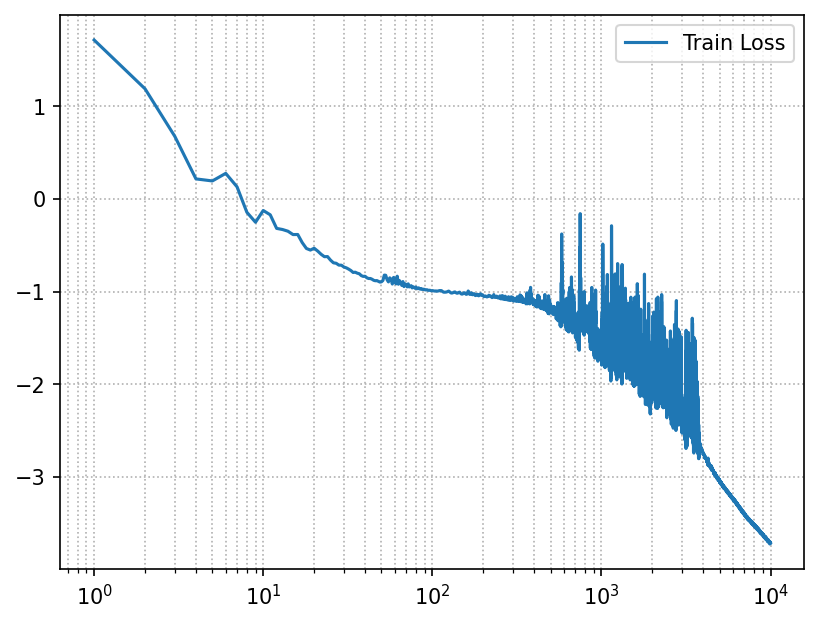

In [7]:
hist = pinn.fit(num_epochs=n_epochs,
                optimizer=optimizer_ADAM,
                verbose=True)

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

torch.Size([256, 100]) torch.Size([256, 100])
L2 Error= tensor(0.0004, grad_fn=<MeanBackward0>)


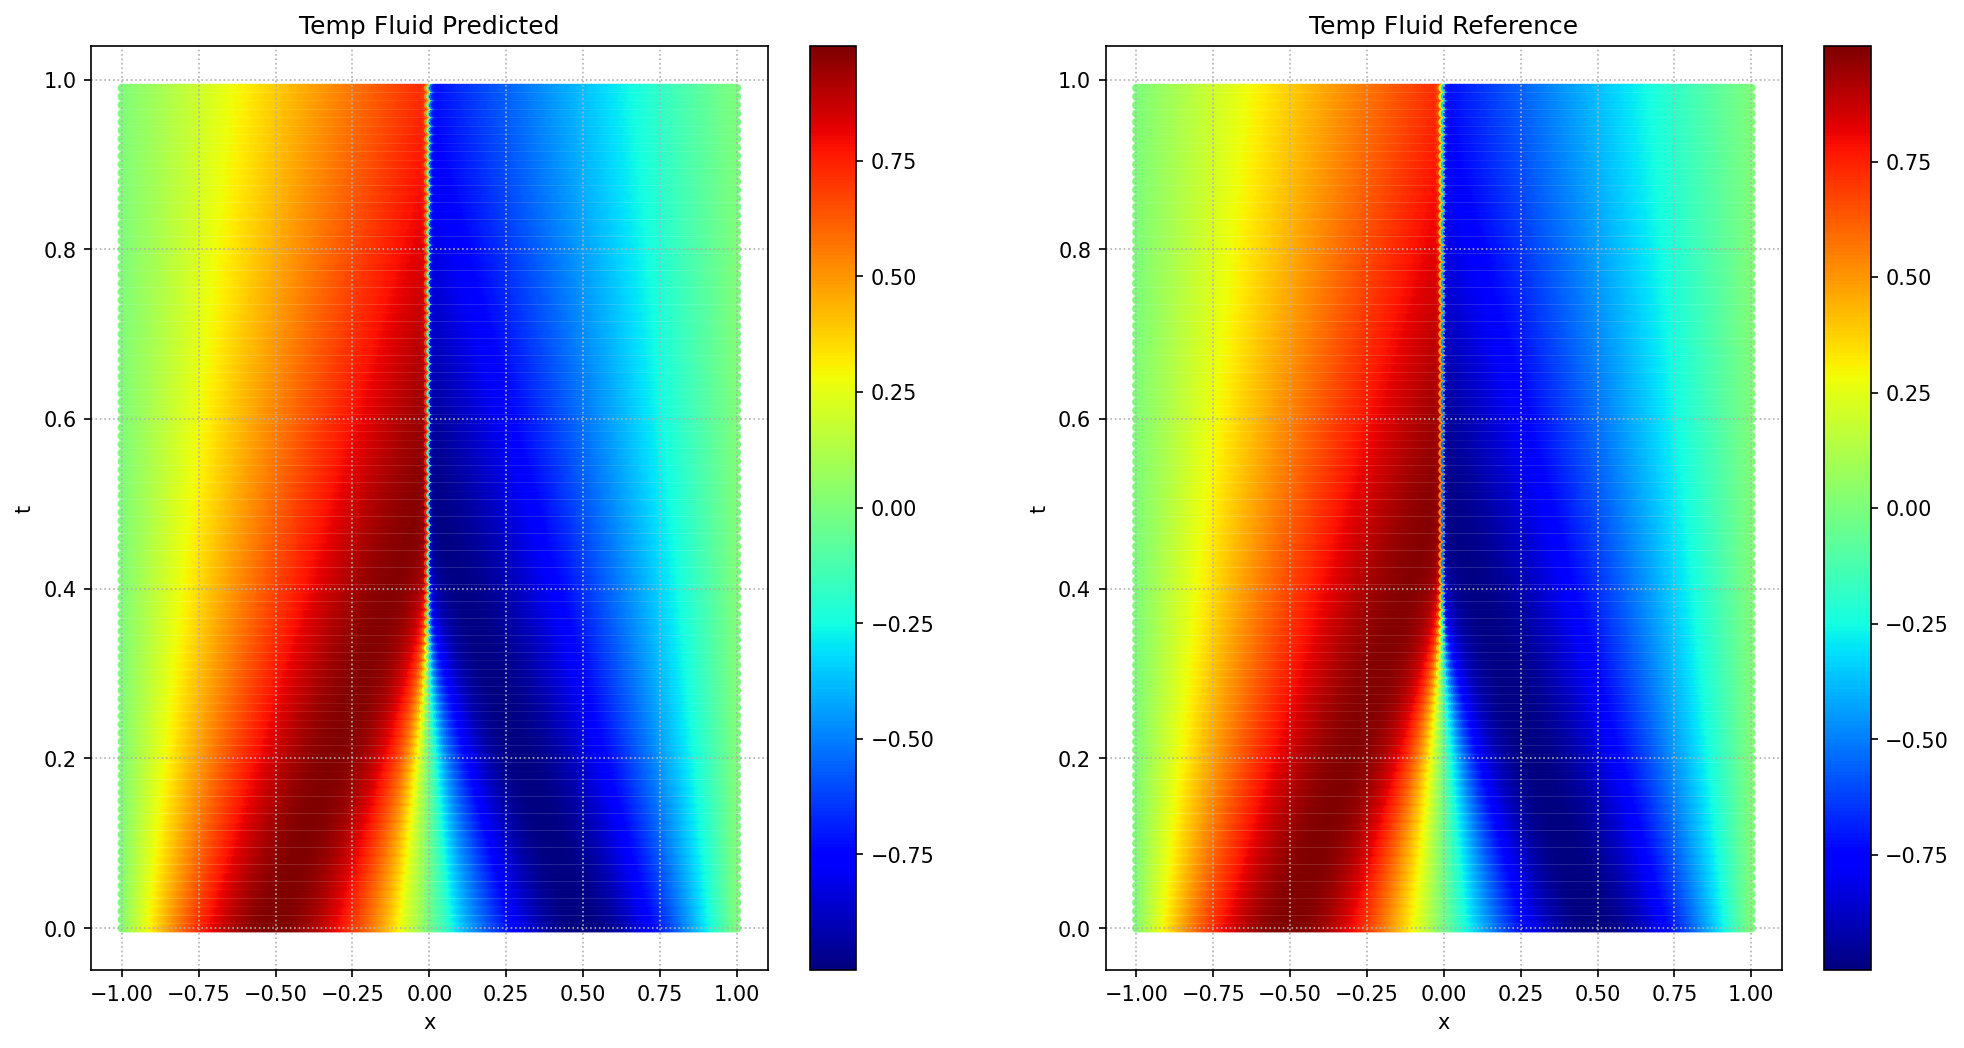

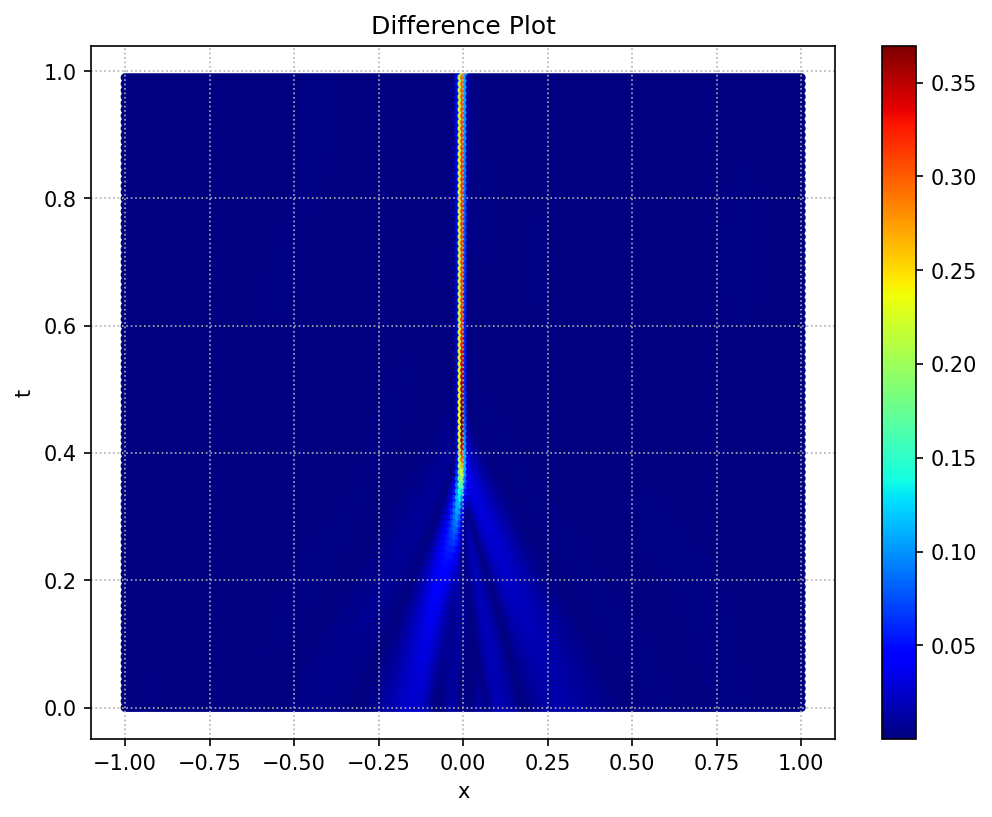

In [8]:
# Load Reference Values
data = np.load(r'C:\Users\matth\git\dlsc\Burgers_Equation\data\Burgers.npz')

t, x, exact = data["t"], data["x"], data["usol"]
tt, xx = np.meshgrid(t, x)
inputs_ref = np.vstack((np.ravel(tt), np.ravel(xx))).T
inputs_ref = torch.from_numpy(inputs_ref).to(torch.float32)

outputs_ref = torch.from_numpy(exact).to(torch.float32)


def plotting_compare(pinn):
        outputs_pinn = pinn.approximate_solution_fluid(inputs_ref.to(device)).reshape(256,100).cpu()
        print(outputs_pinn.shape, outputs_ref.shape)
        difference = torch.abs(outputs_pinn-outputs_ref)
        L2err = torch.mean(abs(outputs_pinn-outputs_ref)**2)
        print("L2 Error=",L2err)
        #vmin = outputs_ref.min()
        #vmax = outputs_ref.max()

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(inputs_ref[:, 1].detach(), inputs_ref[:, 0].detach(), c=outputs_pinn.detach(), cmap="jet", s=10 )#vmin=vmin, vmax=vmax)
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("t")
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")

        im2 = axs[1].scatter(inputs_ref[:, 1].detach(), inputs_ref[:, 0].detach(), c=outputs_ref, cmap="jet", s=10 )#vmin=vmin, vmax=vmax)
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("t")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")

        axs[0].set_title("Temp Fluid Predicted")
        axs[1].set_title("Temp Fluid Reference")

        plt.show()

        fig2, ax3 = plt.subplots(figsize=(8, 6), dpi=150)
        im3 = ax3.scatter(inputs_ref[:, 1].detach(), inputs_ref[:, 0].detach(), c=difference.detach(), cmap="jet", s=10)
        ax3.set_xlabel("x")
        ax3.set_ylabel("t")
        plt.colorbar(im3, ax=ax3)
        ax3.grid(True, which="both", ls=":")
        ax3.set_title("Difference Plot")

        plt.show()


plotting_compare(pinn)

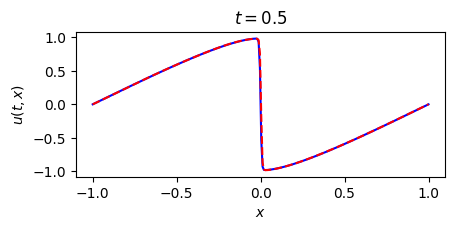

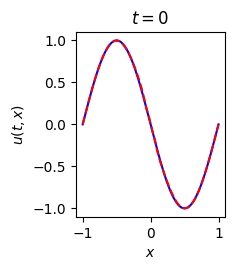

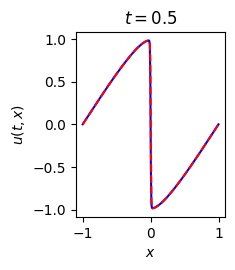

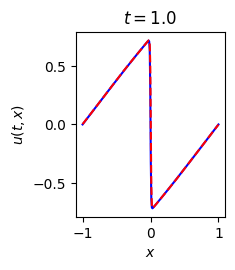

In [9]:
outputs_pinn = pinn.approximate_solution_fluid(inputs_ref.to(device)).reshape(256,100).cpu()

fig = plt.figure(figsize=(13, 4))

plt.subplot(2, 3, 2)
plt.plot(x, exact[:, 50], color='blue')
plt.plot(x, outputs_pinn[:, 50].cpu().detach().numpy(), '--', color='red')
plt.xlabel('$x$')
plt.ylabel('$u(t, x)$')
plt.title('$t = 0.5$')
plt.tight_layout()
plt.show()

plt.subplot(2, 3, 2)
plt.plot(x, exact[:, 0], color='blue')
plt.plot(x, outputs_pinn[:, 0].cpu().detach().numpy(), '--', color='red')
plt.xlabel('$x$')
plt.ylabel('$u(t, x)$')
plt.title('$t = 0$')
plt.tight_layout()
plt.show()


plt.subplot(2, 3, 2)
plt.plot(x, exact[:, 50], color='blue')
plt.plot(x, outputs_pinn[:, 50].cpu().detach().numpy(), '--', color='red')
plt.xlabel('$x$')
plt.ylabel('$u(t, x)$')
plt.title('$t = 0.5$')
plt.tight_layout()
plt.show()

plt.subplot(2, 3, 2)
plt.plot(x, exact[:, -1], color='blue')
plt.plot(x, outputs_pinn[:, -1].cpu().detach().numpy(), '--', color='red')
plt.xlabel('$x$')
plt.ylabel('$u(t, x)$')
plt.title('$t = 1.0$')
plt.tight_layout()
plt.show()

In [10]:
import pandas as pd 

outputs_pinn = pinn.approximate_solution_fluid(inputs_ref.to(device)).cpu()
submission = torch.cat((inputs_ref, outputs_pinn), dim=1)
submission = pd.DataFrame(submission.cpu().detach().numpy())

# Save the DataFrame as a text file
submission.to_csv(r"C:\Users\matth\Downloads\submission_burger.txt", sep=',', index=False, header=['t', 'x', 'u'])